In [6]:
# %%Ren_2022
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False # 顯示負號
import plotly.graph_objects as go

## preprocessing from scikitlearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

## Machine Learning from scikitlearn
from sklearn.metrics import silhouette_score
from sklearn import metrics
# from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

## others
from datetime import datetime as dt
import datetime
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from IPython.display import display
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import yellowbrick

In [60]:
" Machine Learning from scikitlearn "
## 評估分群效果
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score     # BSS/WSS
from sklearn.metrics import davies_bouldin_score  # 大於0情況下,越小越好

In [7]:

# 圖片路徑
RN_VP_PNG_PATH = "/Users/hongshangren/Downloads/ReviewerNumber_VendorPoints.png"
RN_VP_PNG_PATH2= "/Users/hongshangren/Downloads/ReviewerNumber_VendorPoints2.png"
JSON_PNG_PATH = "/Users/hongshangren/Downloads/Jsonpng.png"
JSON_PNG_PATH2= "/Users/hongshangren/Downloads/Jsonpng2.png"
data_path='/Users/hongshangren/Downloads/1212_FP_data.csv'

- load foodpanda data and display head five rows of data

In [5]:
# read data
df = pd.read_csv(data_path)
display(df.head())


,Restaurant_kind,Restaurant_name,RestaurantID,Restaurant_post,Rate,Reviewer_Number,Vendor_Points,ID_list,long_list,lat_list,...,鐵板燒,早餐,麵食,小吃,健康餐,港式,台式,東南亞,pro專屬優惠,店內價
0,披薩,達美樂 (路竹店),o5bn,821,4.8,627,37761,"179,165,179,55",22.860112,120.259328,...,0,0,0,0,0,0,0,0,0,1
1,便當,古早味排骨飯,x7wu,821,4.6,697,11503,"248,1215,248",22.860617,120.259923,...,0,0,0,0,0,0,1,0,0,0
2,火鍋,客友複合式休閒廣場,xvwq,821,4.6,335,10766,"248,1214,248,55",22.858492,120.256605,...,0,0,0,0,0,0,1,0,0,1
3,早餐,Say Hi 肆海豆漿,oqjp,821,4.8,418,9195,"214,198,214,257",22.862046,120.261017,...,0,1,0,1,0,0,0,0,1,0
4,麵食,停一下 Break Tea複合式餐廳(飲料、甜點、鍋燒),h05u,821,4.6,51,7111,"248,201,248,257",22.864878,120.263891,...,0,0,1,0,0,0,1,0,1,0


- 欄位說明
---
    Rate: 星星分數, 如google那樣, 最高為五分
    Vendor_Points: 爬蟲發現的隱藏分數指標, 具體是什麼則不清楚
    Reviewer_Number: 應該類似瀏覽人數or評論人數

# Functions

- 讀取圖片並展示

In [8]:
def png_func(pic_path):
    """讀取PNG圖片,input image path"""
    lena = mpimg.imread(pic_path)
    # 此時 lena 就已經是一個 np.array 了，可以對它進行任意處理
    lena.shape #(512, 512, 3)
    plt.imshow(lena) # 顯示圖片
    plt.axis('off') # 不顯示座標軸
    plt.figure(figsize=(40,10))
    plt.show()
    

- 簡易EDA function, 瀏覽資料概況

In [9]:
def segmentLine():
    """分隔線"""
    print("-----"*15)
    return

def checkData(data):
    """沒有做處理，只是看data狀況"""
    df_output = data.copy()
    print(f"剛讀取完: (筆數:{len(df_output)})_(欄位數:{len(df_output.columns)})")
    segmentLine()
    print("#各欄位空值數量")
    display(df_output.isnull().sum().to_frame())
    segmentLine()
    print("#前五筆展示")
    display(df_output.head())
    segmentLine()
    print("#型態")
    display(df_output.info())
    segmentLine()
    # print("#value_counts")
    # display(df.value_counts(list(df.columns())))
    return df_output

def viewEachCol(df_input):
    """看每個欄位value種類數量"""
    for each_col in list(df_input.columns):print(f"{each_col}數量: {len(df_input.value_counts([each_col]).to_frame())}")

def viewEachValue_of_eachCol(df_input):
    """看每個欄位的每個值的數量"""
    for each_col in list(df_input.columns):
    # if each_col == "State" or each_col == "City" or each_col == "Region":
    #     print(f"{each_col}數量: {len(df.value_counts([each_col]).to_frame())}")
        display(df_input.value_counts([each_col]).to_frame())


- 做圖func

In [19]:
## plotly_3d(1,rfm)
def RFM_3d(cluster_status, df_input, v1,v2,v3):
    start, end = 100, 1000000
    df_copy = df_input.copy()
    df_copy['mean_m']=5000
    # df_copy= df_copy[df_copy['M']<100000]
    # df_copy= df_copy[df_copy['F']<30]
    # df_copy['mean_m']=df_copy['mean_m']*0.3
    if cluster_status==0:
        # df_copy['mean_m']=5000
        fig = go.Figure(data=go.Scatter3d(
        x=df_copy[v1][start:end],
        y=df_copy[v2][start:end],
        z=df_copy[v3][start:end],
        mode='markers',
        marker=dict(
            sizemode='diameter',
            sizeref=750,
            size=df_copy['mean_m'][start:end],
            # size=df_copy['mean_m_F'][start:end],
            line_color='rgb(140, 140, 170)'
        )
    ))
        fig.update_layout(height=1500, width=1500,title='Examining Population and Life Expectancy Over Time')
        fig.show()

    
    if cluster_status==1:
        fig = go.Figure(data=go.Scatter3d(
            x=df_copy[v1][start:end],
            y=df_copy[v2][start:end],
            z=df_copy[v3][start:end],
            # text=df_copy['country'][start:end],
            mode='markers',
            ## dict
            marker=dict(
                sizemode='diameter',
                sizeref=750,
                # size=df_copy['mean_m_F'][start:end],
                size=df_copy['mean_m'][start:end],
                color = df_copy['Cluster'][start:end],
                colorscale = 'Viridis',
                colorbar_title = 'Life<br>Expectancy',
                line_color='rgb(140, 140, 170)'
            )
            ))
        fig.update_layout(height=1500, width=1500,title='Examining Population and Life Expectancy Over Time')
        fig.show()
        

- 基本散點圖

In [24]:
# scatter_func
def scatter_func(df_input, element1, element2):
    """_散點圖_
    Args:
        df_input (_type_): _data_
        element1 (_type_): _x軸欄位名_
        element2 (_type_): _y軸欄位名_
    """
    plt.scatter(df_input[element1], df_input[element2])
    plt.ylabel(element2)
    plt.xlabel(element1)
    plt.title(element1+' V.S '+element2)
    plt.show()

# 資料概況

In [10]:
viewEachCol(df)
viewEachValue_of_eachCol(df)

Restaurant_kind數量: 23
Restaurant_name數量: 2193
RestaurantID數量: 2193
Restaurant_post數量: 27
Rate數量: 19
Reviewer_Number數量: 1250
Vendor_Points數量: 2038
ID_list數量: 187
long_list數量: 2155
lat_list數量: 2150
Reviewer_percent數量: 1250
count數量: 1
area數量: 27
0數量: 2
粥數量: 2
咖啡輕食數量: 2
餃子數量: 2
炸雞數量: 2
咖哩數量: 2
火鍋數量: 2
便當數量: 2
163數量: 2
日式數量: 2
披薩數量: 2
中式數量: 2
甜點數量: 2
漢堡數量: 2
歐美數量: 2
飲料數量: 2
異國數量: 2
素食數量: 2
韓式數量: 2
鐵板燒數量: 2
早餐數量: 2
麵食數量: 2
小吃數量: 2
健康餐數量: 2
港式數量: 2
台式數量: 2
東南亞數量: 2
pro專屬優惠數量: 2
店內價數量: 2


,0
Restaurant_kind,
早餐,504
麵食,265
小吃,245
台式,224
便當,177
飲料,102
歐美,98
火鍋,89
中式,89


,0
Restaurant_name,
萬客臨早午晚餐三色麵疙瘩,2
056早午餐坊,1
無肉不歡 (楠梓瑞屏店),1
烹大師廣東粥,1
無名海產粥,1
...,...
大碗公冰·甜品 (小港店),1
大珈飯糰,1
大炒一番炒飯,1


,0
RestaurantID,
e8sm,2
a0co,1
p96s,1
p8ia,1
p8sm,1
...,...
f8uw,1
f8rb,1
f8ob,1


,0
Restaurant_post,
811,302
830,220
820,185
831,173
807,162
812,130
813,117
814,113
821,98


,0
Rate,
4.7,755
4.8,696
4.6,344
4.5,135
4.9,98
4.4,48
5.0,31
4.3,29
4.2,19


,0
Reviewer_Number,
1,13
3,13
6,12
14,10
4,10
...,...
896,1
898,1
901,1


,0
Vendor_Points,
10748,3
10383,3
11034,3
14088,3
12570,3
...,...
10875,1
10872,1
10871,1


,0
ID_list,
"248,198,248",138
"248,198,248,55",132
"181,181",102
"248,201,248,55",99
"179,198,179",86
...,...
"188,188,1215,179,55",1
"188,188,1209",1
"186,201,186,257",1


,0
long_list,
22.595829,10
22.515451,6
22.596249,3
22.726389,2
22.616967,2
...,...
22.633129,1
22.633045,1
22.633023,1


,0
lat_list,
120.327599,10
120.394903,6
120.299004,4
120.350998,4
120.307999,3
...,...
120.303200,1
120.303197,1
120.303194,1


,0
Reviewer_percent,
0.000043,13
0.000129,13
0.000259,12
0.000603,10
0.000172,10
...,...
0.038619,1
0.038705,1
0.038834,1


,0
count,
1,2194


,0
area,
楠梓區,302
鳳山區,220
岡山區,185
大寮區,173
三民區,162
小港區,130
左營區,117
仁武區,113
路竹區,98


,0
0,
0,2193
1,1


,0
粥,
0,2155
1,39


,0
咖啡輕食,
0,2141
1,53


,0
餃子,
0,2133
1,61


,0
炸雞,
0,2065
1,129


,0
咖哩,
0,2172
1,22


,0
火鍋,
0,2088
1,106


,0
便當,
0,2005
1,189


,0
163,
0,2191
1,3


,0
日式,
0,2063
1,131


,0
披薩,
0,2147
1,47


,0
中式,
0,2104
1,90


,0
甜點,
0,2106
1,88


,0
漢堡,
0,2135
1,59


,0
歐美,
0,1820
1,374


,0
飲料,
0,2039
1,155


,0
異國,
0,2193
1,1


,0
素食,
0,2177
1,17


,0
韓式,
0,2177
1,17


,0
鐵板燒,
0,2178
1,16


,0
早餐,
0,1689
1,505


,0
麵食,
0,1885
1,309


,0
小吃,
0,1919
1,275


,0
健康餐,
0,2174
1,20


,0
港式,
0,2181
1,13


,0
台式,
0,1119
1,1075


,0
東南亞,
0,2170
1,24


,0
pro專屬優惠,
0,1663
1,531


,0
店內價,
0,1180
1,1014


In [11]:
df.columns

Index(['Restaurant_kind', 'Restaurant_name', 'RestaurantID', 'Restaurant_post',
       'Rate', 'Reviewer_Number', 'Vendor_Points', 'ID_list', 'long_list',
       'lat_list', 'Reviewer_percent', 'count', 'area', '0', '粥', '咖啡輕食', '餃子',
       '炸雞', '咖哩', '火鍋', '便當', '163', '日式', '披薩', '中式', '甜點', '漢堡', '歐美', '飲料',
       '異國', '素食', '韓式', '鐵板燒', '早餐', '麵食', '小吃', '健康餐', '港式', '台式', '東南亞',
       'pro專屬優惠', '店內價'],
      dtype='object')

# Rate, Reviewer_Number, Vendor_Points散點圖
---
    Y軸為Vendor_Points
    X軸為Rate(左圖)、Reviewer_Number(右圖)
    大部分的情況,高雄民眾所能看到的店家分數大多為4分以上(Rate=星星分數)

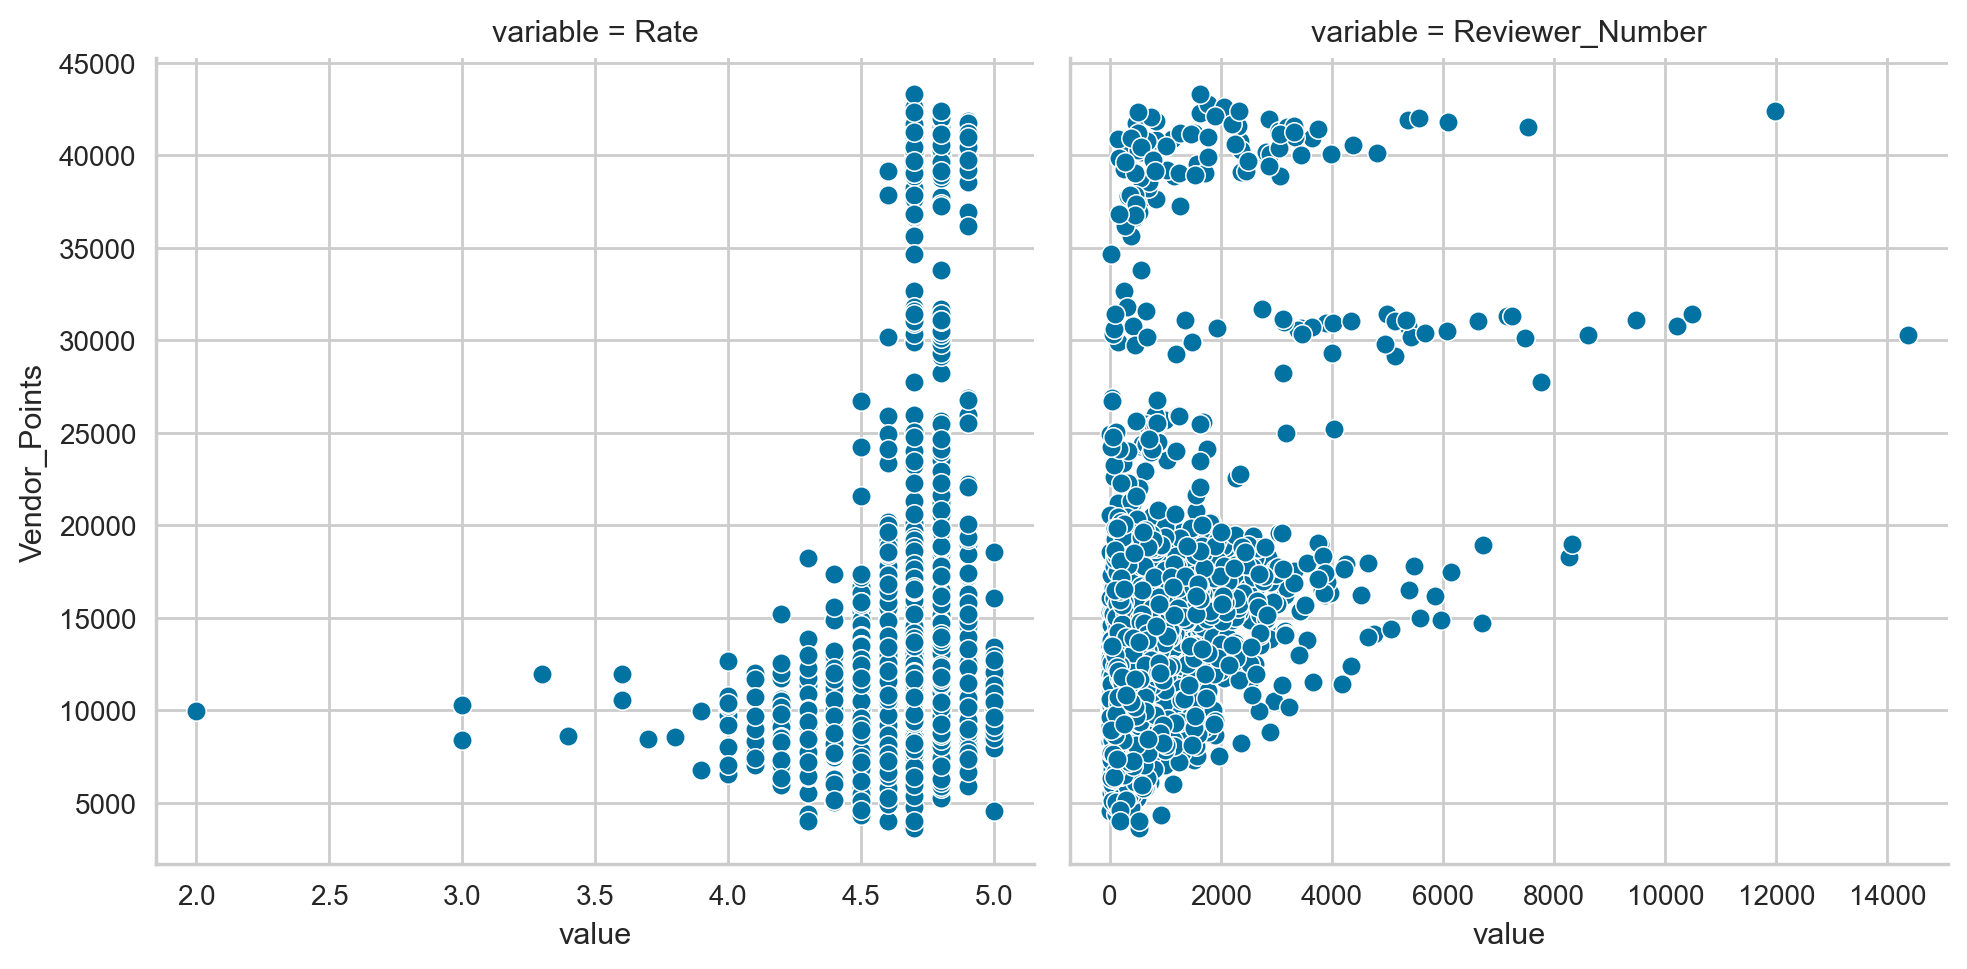

In [18]:
# 提高解析度
%config InlineBackend. figure_format = 'retina'
features = ["Rate", "Reviewer_Number"]
sns.relplot(x="value", y="Vendor_Points", col="variable", data=df.melt(id_vars="Vendor_Points", value_vars=features), facet_kws=dict(sharex=False),);
plt.show()

- 3D圖, XYZ=vp,rate,reviewer_number

In [112]:
df_plot_copy=df.copy()
plot_values=['Rate','Reviewer_Number','Vendor_Points']
RFM_3d(0, df_plot_copy, 'Vendor_Points','Rate','Reviewer_Number')

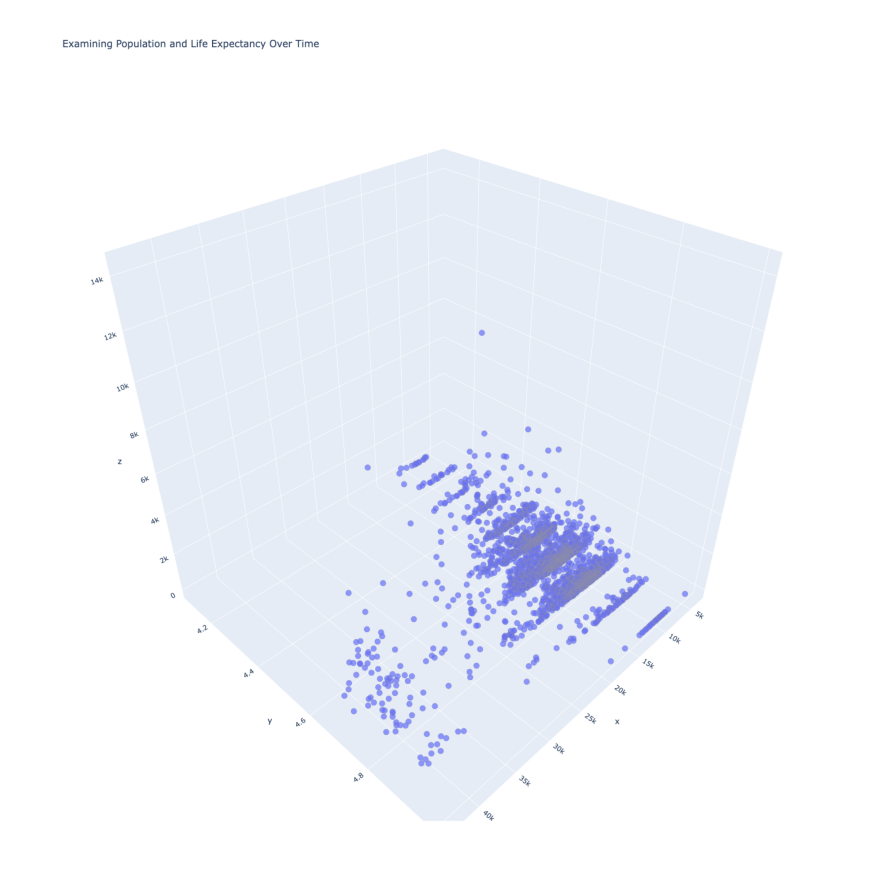

<Figure size 4000x1000 with 0 Axes>

In [111]:
# png_func("/Users/hongshangren/Desktop/作品集ALL/foodpanda資料/newplot_after_clustering.png")
png_func("/Users/hongshangren/Desktop/作品集ALL/foodpanda資料/newplot_before_clustering.png")

# FoodPanda 店家大部分的評價(星星數)都很高很可能是因為計算方法,民眾所看到的分數並不單純只是店家分數,外送員的影響也包含在其中
---
    一個店家的分數方式為,由許多項目評分後(如食物、外送員、是否準時等..),取平均值,
    原因可能是預設值的存在：將某項數值分數打低,而其他分數為預設值5分,
    如此一來,店家分數總是很高,
    如下圖示例,來源為FoodPanda業者網頁,利用API以get method 取得json data
    圖中,restaurant_food指標為2分,其他指標為預設值5,因此4.25為該店家分數.
    #因此,民眾所看到的分數並不單純只是店家分數,外送員的影響也包含在其中
    #目前計算方式似乎有些微修改

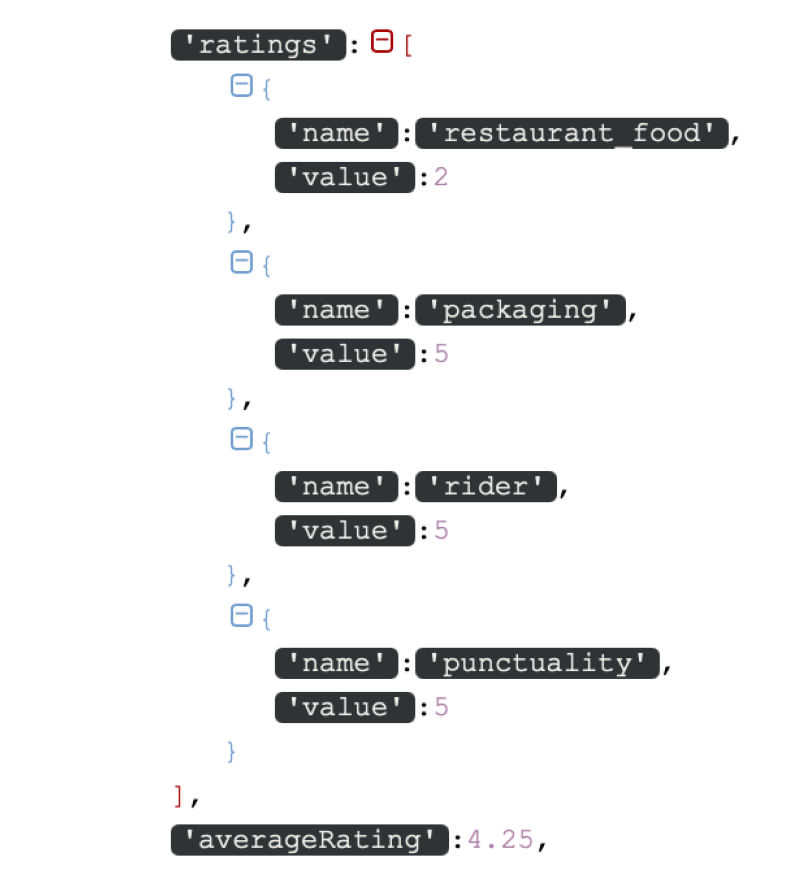

<Figure size 4000x1000 with 0 Axes>

In [23]:
png_func("/Users/hongshangren/Desktop/作品集ALL/foodpanda資料/Jsonpng.png")

- 不同評分的數量，大多的店家為4.7 & 4.8,且幾乎都高於4.3顆星


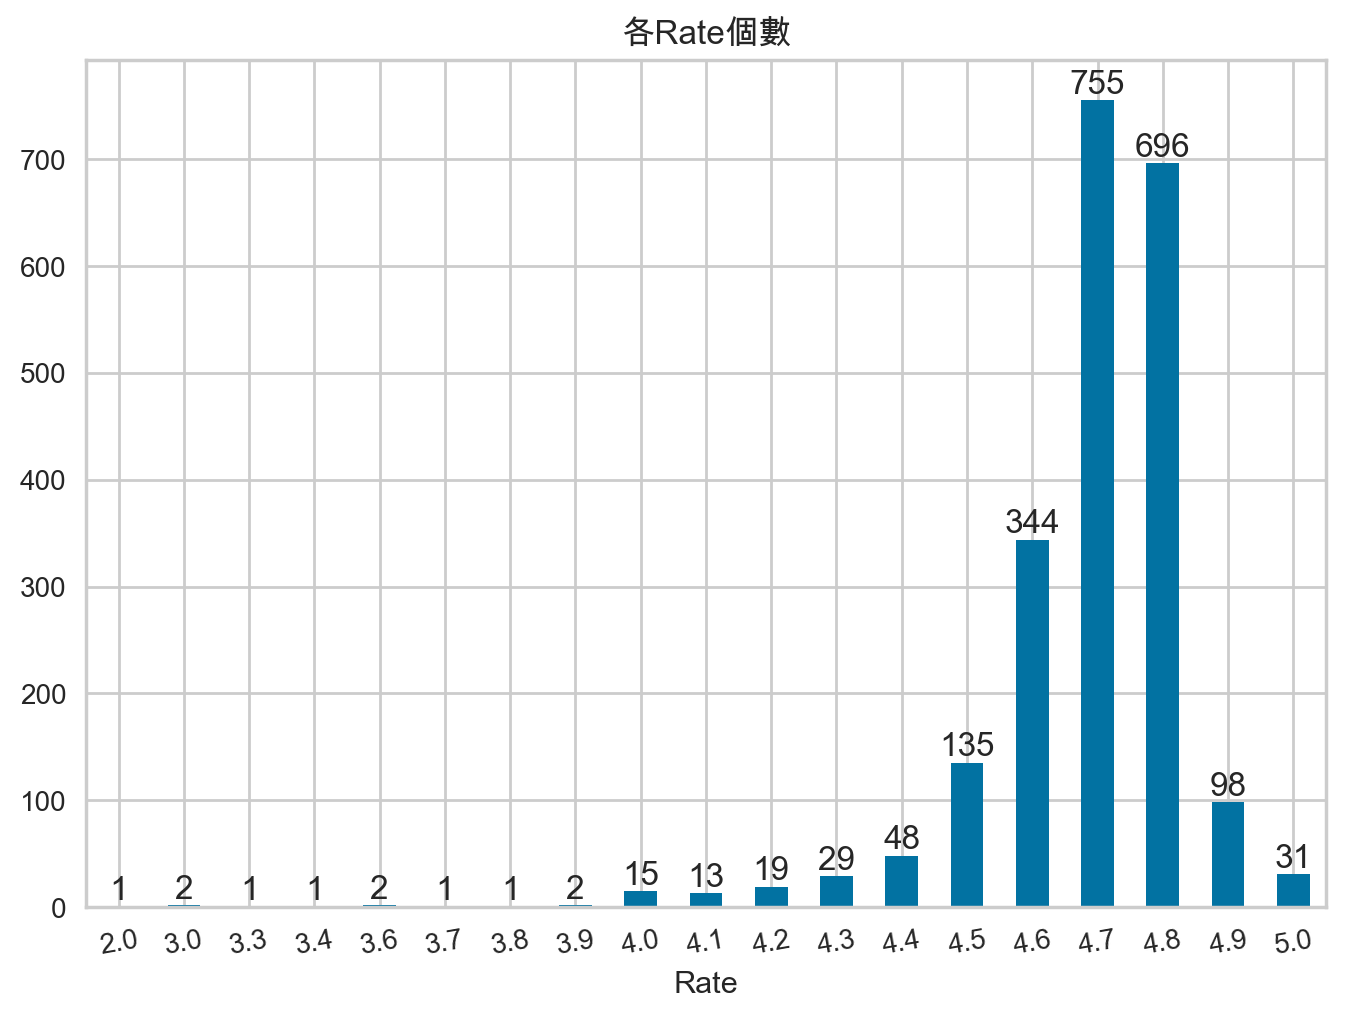

None


In [30]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

def element_count_func(df_input, element1):
    """_計算不同評分的出現次數_

    Args:
        df_input (_type_): _description_
        element1 (_type_): _description_
    """
    ax = df_input.groupby(element1)['count'].sum().plot(kind='bar')
    plt.xticks(rotation=10)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title('各'+element1+'個數')
    plt.show()

df_input=df.copy()
print(element_count_func(df_input, 'Rate'))

# Check three elements: Rate, Reviewer Number, Vendor Points
- 由3D圖我們可以得知,3個指標似乎存在著不同集中趨勢,
- 看看大約都是什麼店家
- 由下圖為準,接續說明

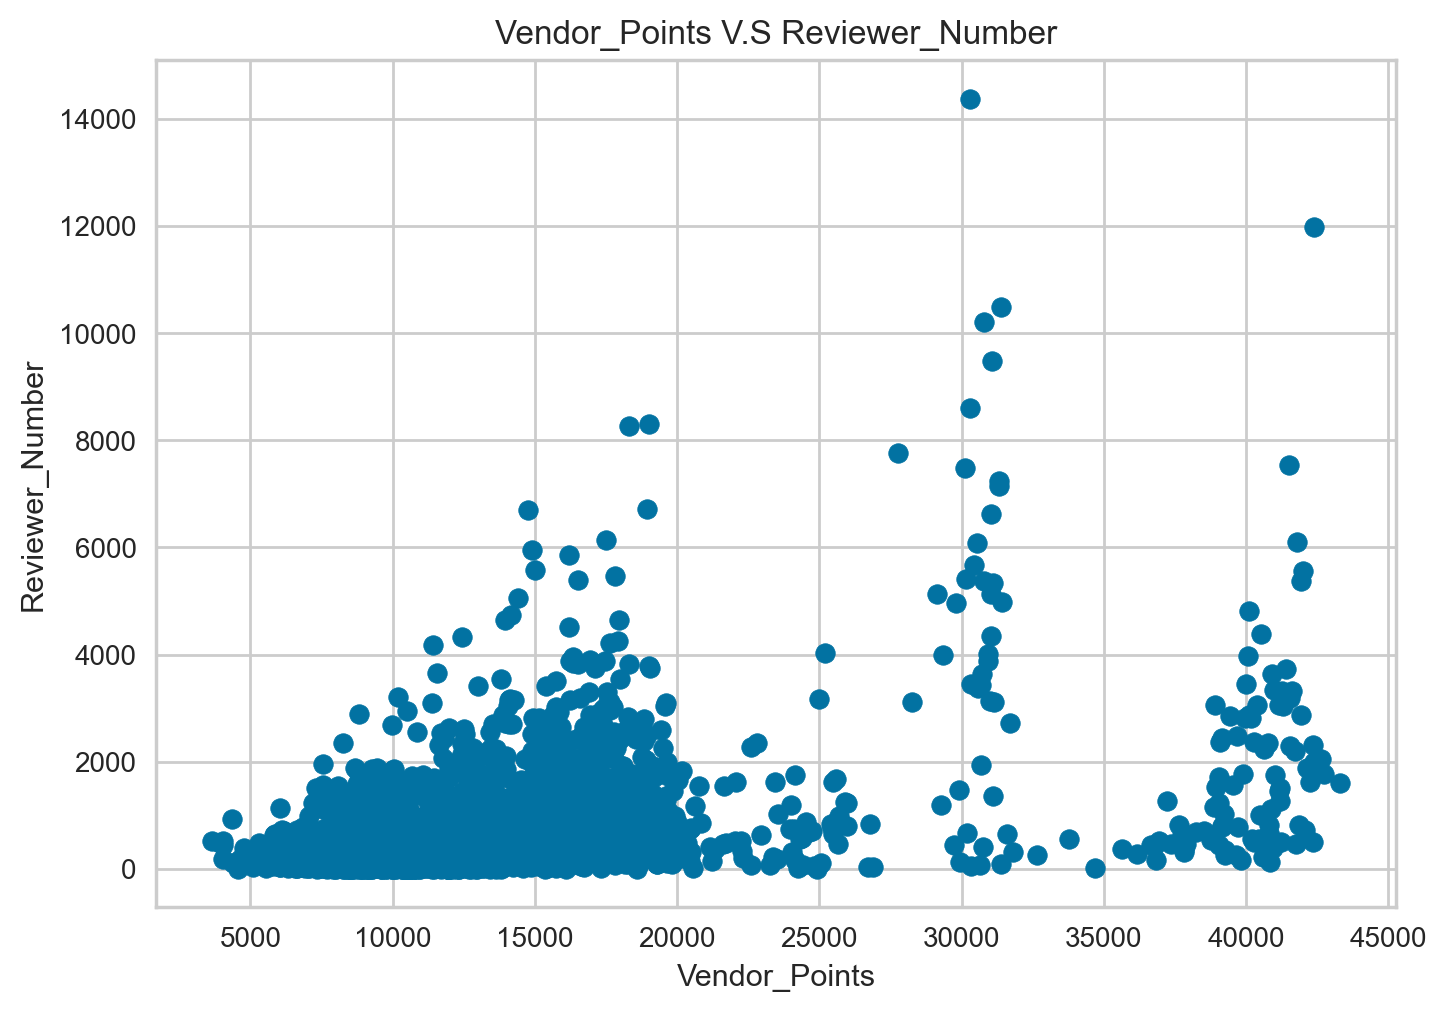

None


In [25]:
# Vendor > 40000 and Reviewer_Number>2000 最右邊那坨
copy_df = df.copy()
print(scatter_func(copy_df, 'Vendor_Points', 'Reviewer_Number'))

- 1. vendor_points&reviewer number高的店家似乎都為連鎖企業

In [26]:
# 大部分都是肯德基麥當勞啥之類的
copy_df = df.copy()
copy_df = copy_df[copy_df['Vendor_Points']>40000]
copy_df[copy_df['Reviewer_Number']>2000]

,Restaurant_kind,Restaurant_name,RestaurantID,Restaurant_post,Rate,Reviewer_Number,Vendor_Points,ID_list,long_list,lat_list,...,鐵板燒,早餐,麵食,小吃,健康餐,港式,台式,東南亞,pro專屬優惠,店內價
164,甜點,肯德基KFC (高雄岡山店),b9ku,820,4.7,3646,40923,"179,176,179,1209",22.793895,120.295766,...,0,0,0,0,0,0,0,0,0,0
184,咖啡輕食,STARBUCKS 星巴克 (岡山門市),e9hu,820,4.8,2346,40790,"179,1206,179,181,55",22.796199,120.298774,...,0,0,0,0,0,0,0,0,0,1
197,披薩,Pizza Hut必勝客 (高雄岡山店),b1zb,820,4.7,2868,41939,"179,165,179",22.791800,120.295998,...,0,0,0,0,0,0,0,0,0,0
471,甜點,肯德基KFC (高雄楠梓二店),z2ze,811,4.7,6094,41808,"179,176,179,1209",22.726948,120.326822,...,0,0,0,0,0,0,0,0,0,0
660,甜點,肯德基KFC (高雄後昌店),z4sv,811,4.7,3981,40067,"179,176,179,1209",22.718599,120.292000,...,0,0,0,0,0,0,0,0,0,0
681,漢堡,摩斯漢堡Mos Burger (高雄右昌店),f6ia,811,4.8,3341,40985,"164,177,164,55",22.718630,120.284874,...,0,0,0,0,0,0,0,0,0,1
755,披薩,Pizza Hut必勝客 (高雄建楠店),z0jv,811,4.7,3038,41321,"179,165,179",22.727014,120.326081,...,0,0,0,0,0,0,0,0,0,0
772,披薩,Pizza Hut必勝客 (高雄楠梓店),z6bu,811,4.7,2817,40171,"179,165,179",22.708200,120.299004,...,0,0,0,0,0,0,0,0,0,0
1072,漢堡,Burger King 漢堡王 (高雄建工店),m8td,807,4.7,3739,41406,"179,177,179,257",22.649446,120.323800,...,0,0,0,0,0,0,0,0,1,0
1137,甜點,肯德基KFC (高雄大順二店),y7ne,807,4.7,2874,40092,"179,176,179,1209",22.644507,120.326234,...,0,0,0,0,0,0,0,0,0,0


- Vendor_Points between 0 and 25000: 最左邊的群集,大多為平價餐廳:便當、早餐等..

In [27]:
copy_df = df[df['Vendor_Points']>0].copy()
display(copy_df[copy_df['Vendor_Points']<25000])

,Restaurant_kind,Restaurant_name,RestaurantID,Restaurant_post,Rate,Reviewer_Number,Vendor_Points,ID_list,long_list,lat_list,...,鐵板燒,早餐,麵食,小吃,健康餐,港式,台式,東南亞,pro專屬優惠,店內價
1,便當,古早味排骨飯,x7wu,821,4.6,697,11503,"248,1215,248",22.860617,120.259923,...,0,0,0,0,0,0,1,0,0,0
2,火鍋,客友複合式休閒廣場,xvwq,821,4.6,335,10766,"248,1214,248,55",22.858492,120.256605,...,0,0,0,0,0,0,1,0,0,1
3,早餐,Say Hi 肆海豆漿,oqjp,821,4.8,418,9195,"214,198,214,257",22.862046,120.261017,...,0,1,0,1,0,0,0,0,1,0
4,麵食,停一下 Break Tea複合式餐廳(飲料、甜點、鍋燒),h05u,821,4.6,51,7111,"248,201,248,257",22.864878,120.263891,...,0,0,1,0,0,0,1,0,1,0
7,早餐,早安山丘 (湖內東方店),qlfr,829,4.7,2728,13946,"248,198,248",22.880027,120.249294,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,便當,宋主廚香菇肉羹、肉燥飯,rrqo,832,4.9,127,7366,"248,1215,248,55",22.503638,120.392875,...,0,0,0,0,0,0,1,0,0,1
2190,火鍋,五鮮級平價鍋物 (高雄林園店),nezf,832,4.6,293,10815,"248,1214,248,55",22.503831,120.383776,...,0,0,0,0,0,0,1,0,0,1
2191,東南亞,How2食堂,ftlk,832,4.5,16,8947,"252,252,257",22.503046,120.380359,...,0,0,0,0,0,0,0,1,1,0
2192,甜點,有米樂甜品,k0kh,832,4.8,252,9295,"176,176",22.503940,120.385452,...,0,0,0,0,0,0,0,0,0,0


- Vendor_Points between 30000 and 35000: 中間的群集，除了連鎖企業外也有些較有名的本土企業

In [28]:
copy_df = df[df['Vendor_Points']>27000].copy()
copy_df[copy_df['Vendor_Points']<35000]

,Restaurant_kind,Restaurant_name,RestaurantID,Restaurant_post,Rate,Reviewer_Number,Vendor_Points,ID_list,long_list,lat_list,...,鐵板燒,早餐,麵食,小吃,健康餐,港式,台式,東南亞,pro專屬優惠,店內價
6,漢堡,麥當勞 (S266 高雄路竹店),k0nl,821,4.8,7145,31327,"179,177,179",22.853921,120.261529,...,0,0,0,0,0,0,0,0,0,0
195,漢堡,麥當勞 (S316 岡山中山店),b2fu,820,4.8,8612,30308,"179,177,179",22.795871,120.298567,...,0,0,0,0,0,0,0,0,0,0
291,漢堡,麥當勞 (S481 岡山壽天店),r8z3,820,4.8,3120,28256,"179,177,179",22.794458,120.290756,...,0,0,0,0,0,0,0,0,0,0
389,漢堡,麥當勞 (S482 橋頭成功南店),c5it,825,4.8,5367,30788,"179,177,179",22.749493,120.314017,...,0,0,0,0,0,0,0,0,0,0
449,歐美,大亨牛排 (高雄大社店),d8qq,815,4.7,1475,29906,"179,179,55",22.731066,120.355405,...,0,0,0,0,0,0,0,0,0,1
473,歐美,食大客平價炙燒牛排 (高雄楠梓店),yg0f,811,4.7,139,29930,"179,179,257",22.727596,120.309926,...,0,0,0,0,0,0,0,0,1,0
606,歐美,板塊牛排 (高雄楠梓店),ivro,811,4.8,411,30753,"179,179,55",22.724830,120.324808,...,0,0,0,0,0,0,0,0,0,1
613,漢堡,麥當勞 (S183 高雄楠梓店),b2wy,811,4.8,14371,30304,"179,177,179",22.727015,120.326547,...,0,0,0,0,0,0,0,0,0,0
736,漢堡,麥當勞 (S153 高雄右昌店),b6wb,811,4.8,10212,30786,"179,177,179",22.709878,120.293049,...,0,0,0,0,0,0,0,0,0,0
777,漢堡,麥當勞 (S264 高雄後勁店),b6lw,811,4.7,7239,31306,"179,177,179",22.718930,120.310674,...,0,0,0,0,0,0,0,0,0,0


# 各地區熊貓店家數: 楠梓, 鳳山, 岡山, 大寮,三民,小港

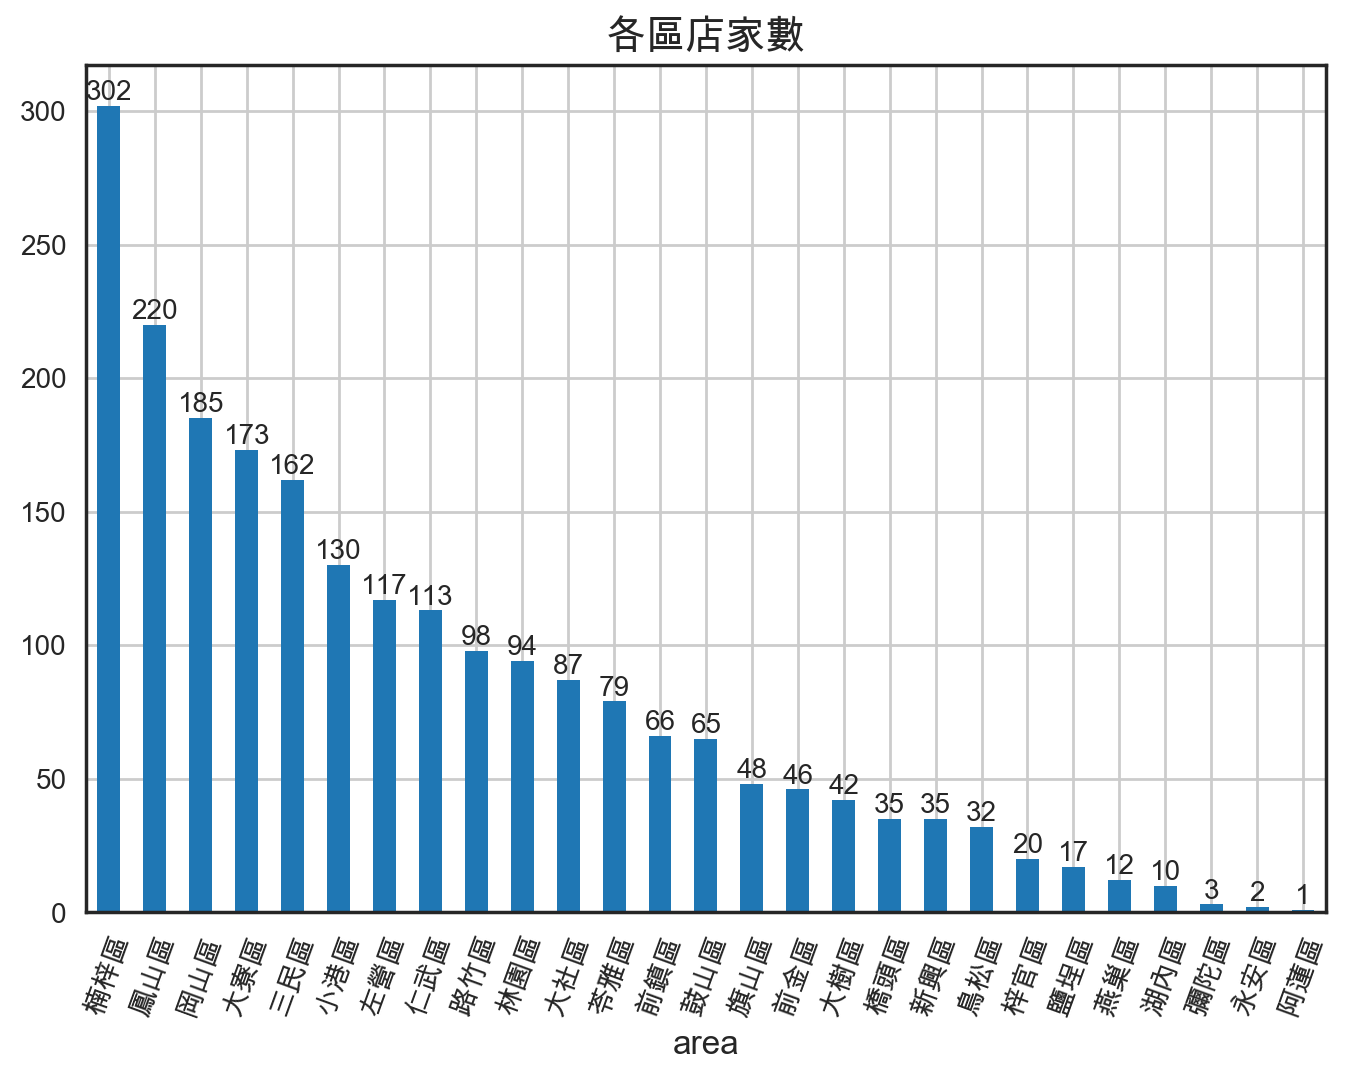

<Figure size 2500x1000 with 0 Axes>

In [36]:
# 各區 店家數
df_plot_copy=df.copy()
color_ = 'skyblue'
# plt.style.use('tableau-colorblind10')
plt.style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
ax = df_plot_copy.value_counts('area').plot(kind='bar', color='tab:blue')
for container in ax.containers: ax.bar_label(container) # 柱子上的數字

plt.xticks(rotation=70)
plt.title('各區店家數')
plt.grid()
plt.figure(figsize=(25,10))
plt.show()

# 綜合表: 每個元素的平均值: Rate, Reviewr_Number, Vendor_Points

In [38]:




# 1. 
def culture_cal(df, element1, element2):
    """計算什麼種類的 Rate, VP, RN -> EX:df, 日式, Rate
    Args:
        df (_type_): _data_
        element1 (_type_): _元素, EX: 火鍋、日式、披薩等.._
        element2 (_type_): _要計算的value, EX: _
    Returns:
        _int_: _目標元素的平均分數_
    """
    df = df[df[element1] == 1].groupby([element1])[element2].mean().reset_index()
    score = df[element2].values[0]
    return df, score

def culture_cal_2(df,cal_element, culture_list, score_list):
    """2. return score list
            cal_element = Rate, RN, VP
            score list = []"""
    for i in range(len(culture_list)):
        target_df, score = culture_cal(df, culture_list[i], cal_element)
        score_list.append(score)
        
    return score_list


# 4. return 
def cluster_mean_score_df(df,list):
    rate_sl = culture_cal_2(df,"Rate", list, [])
    rn_sl = culture_cal_2(df,"Reviewer_Number", list, [])
    vp_sl = culture_cal_2(df,"Vendor_Points", list, [])
    
    # 筆數計算
    empty_list = []
    for i in list:
        empty_list.append(len(df[df[i]==1]))

    # 丟 cul_list, score_list, title_element, method(計算方法)
    culture_score_df = pd.DataFrame({
        'Culture': list,
        'Rate_score': rate_sl,
        'RN_score': rn_sl,
        'VP_score': vp_sl,
        '筆數': empty_list
    })
    return culture_score_df

- 不同標籤在三個指標的平均分數,
- Rate_score=星星數平均值
- RN_score=Reviewer Number平均值
- VP_score=Vendor_Points平均值

In [39]:
# list
food_element_list = ['早餐', '漢堡', '便當', '小吃', '麵食']
culture_list = ['台式', '中式', '港式', '歐美', '日式', '韓式', '東南亞', '健康餐','早餐', '漢堡', '便當', '小吃', '麵食','鐵板燒','飲料','店內價','pro專屬優惠','炸雞']
# ori df
df_rrv= cluster_mean_score_df(df, culture_list)
df_rrv.set_index('Culture', inplace=True)
print('## Original')
display(df_rrv)


## Original


,Rate_score,RN_score,VP_score,筆數
Culture,,,,
台式,4.664744,771.537674,12717.517209,1075
中式,4.701111,907.655556,12149.711111,90
港式,4.576923,349.846154,10798.153846,13
歐美,4.747594,1363.518717,21597.973262,374
日式,4.692366,937.335878,16852.618321,131
韓式,4.629412,816.882353,14221.823529,17
東南亞,4.537500,295.083333,12134.625000,24
健康餐,4.655000,206.400000,11134.250000,20
早餐,4.737624,830.594059,12207.354455,505


In [40]:
color_ = 'skyblue'
import pylab

def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """ https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars """
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_bars = len(data)
    bar_width = total_width / n_bars
    bars = []
    for i, (name, values) in enumerate(data.items()):
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
        bars.append(bar[0])
    for container in ax.containers:
        ax.bar_label(container)
    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())



- 各項目出現筆數（一店家可擁有不只一個標籤,但仍可以粗略的比較）
- 顯然的, 大部分的店家都說自己是店內價
- 除了店內價, 台式與早餐出現次數較多,可以推測出較多的早餐店或台式餐飲店會透過foodpanda接收訂單

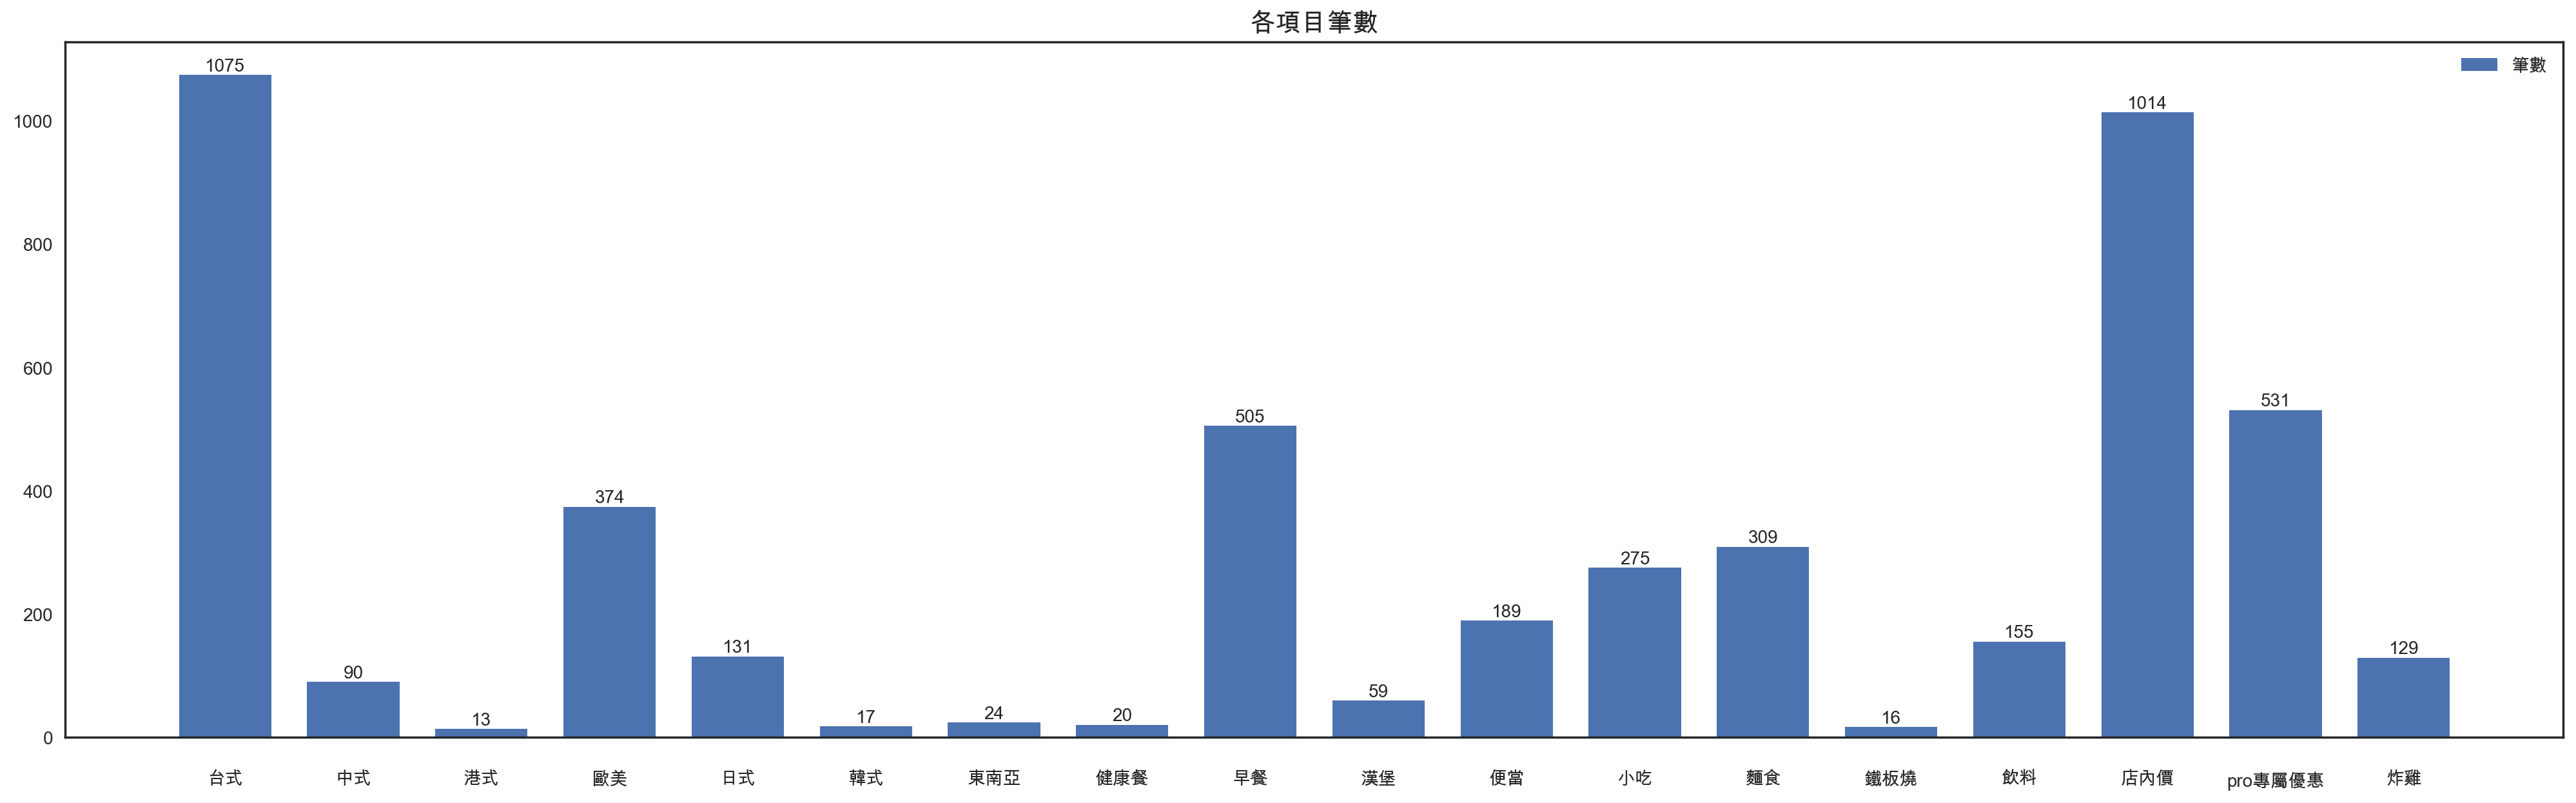

In [55]:
df_copy=df_rrv.copy()
x_label=df_copy.index
plot_data={
    # "Rate_score": df_rrv["Rate_score"],
    # "RN_score": df_rrv["RN_score"],
    # "VP_score": df_rrv["VP_score"],
    "筆數":df_rrv["筆數"],
}


fig, ax = plt.subplots(figsize=(25,7))
plt.xticks(range(18), x_label)
bar_plot(ax, plot_data ,total_width=.8, single_width=.9)
plt.title('各項目筆數')
pylab.rcParams['xtick.major.pad']='19'
plt.show()

- 各項目平均星星數(Rate_score)
- 不論什麼類別, 評分都相當接近, foodpanda上的店家評分參考價值可能不高

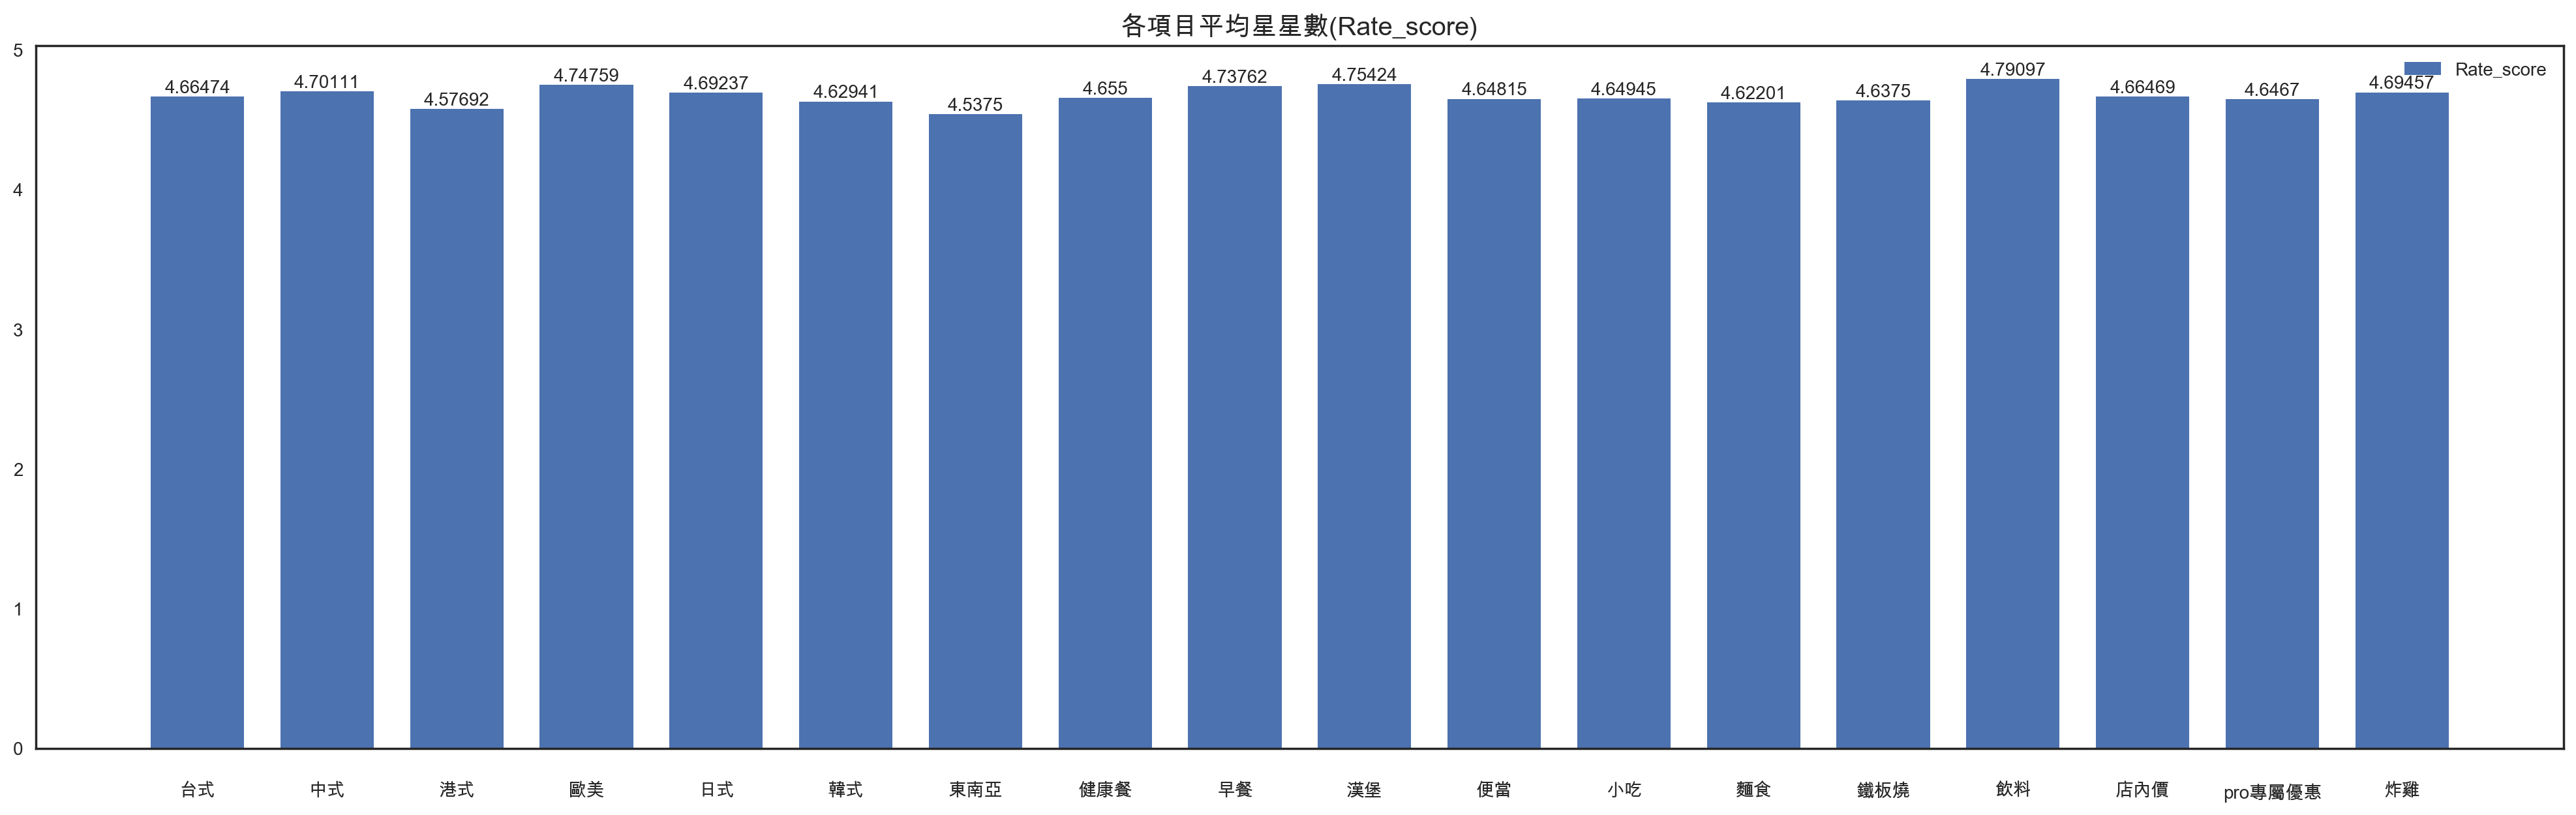

In [57]:
df_copy=df_rrv.copy()
x_label=df_copy.index
plot_data={"Rate_score": df_rrv["Rate_score"],}
fig, ax = plt.subplots(figsize=(25,7))
plt.xticks(range(18), x_label)
bar_plot(ax, plot_data ,total_width=.8, single_width=.9)
plt.title('各項目平均星星數(Rate_score)')
pylab.rcParams['xtick.major.pad']='19'
plt.show()

- 各項目平均(Reviewer_Number)
- Reviewer_Number項目明顯高過其他,而這個指標可能是瀏覽人數或是評論人數

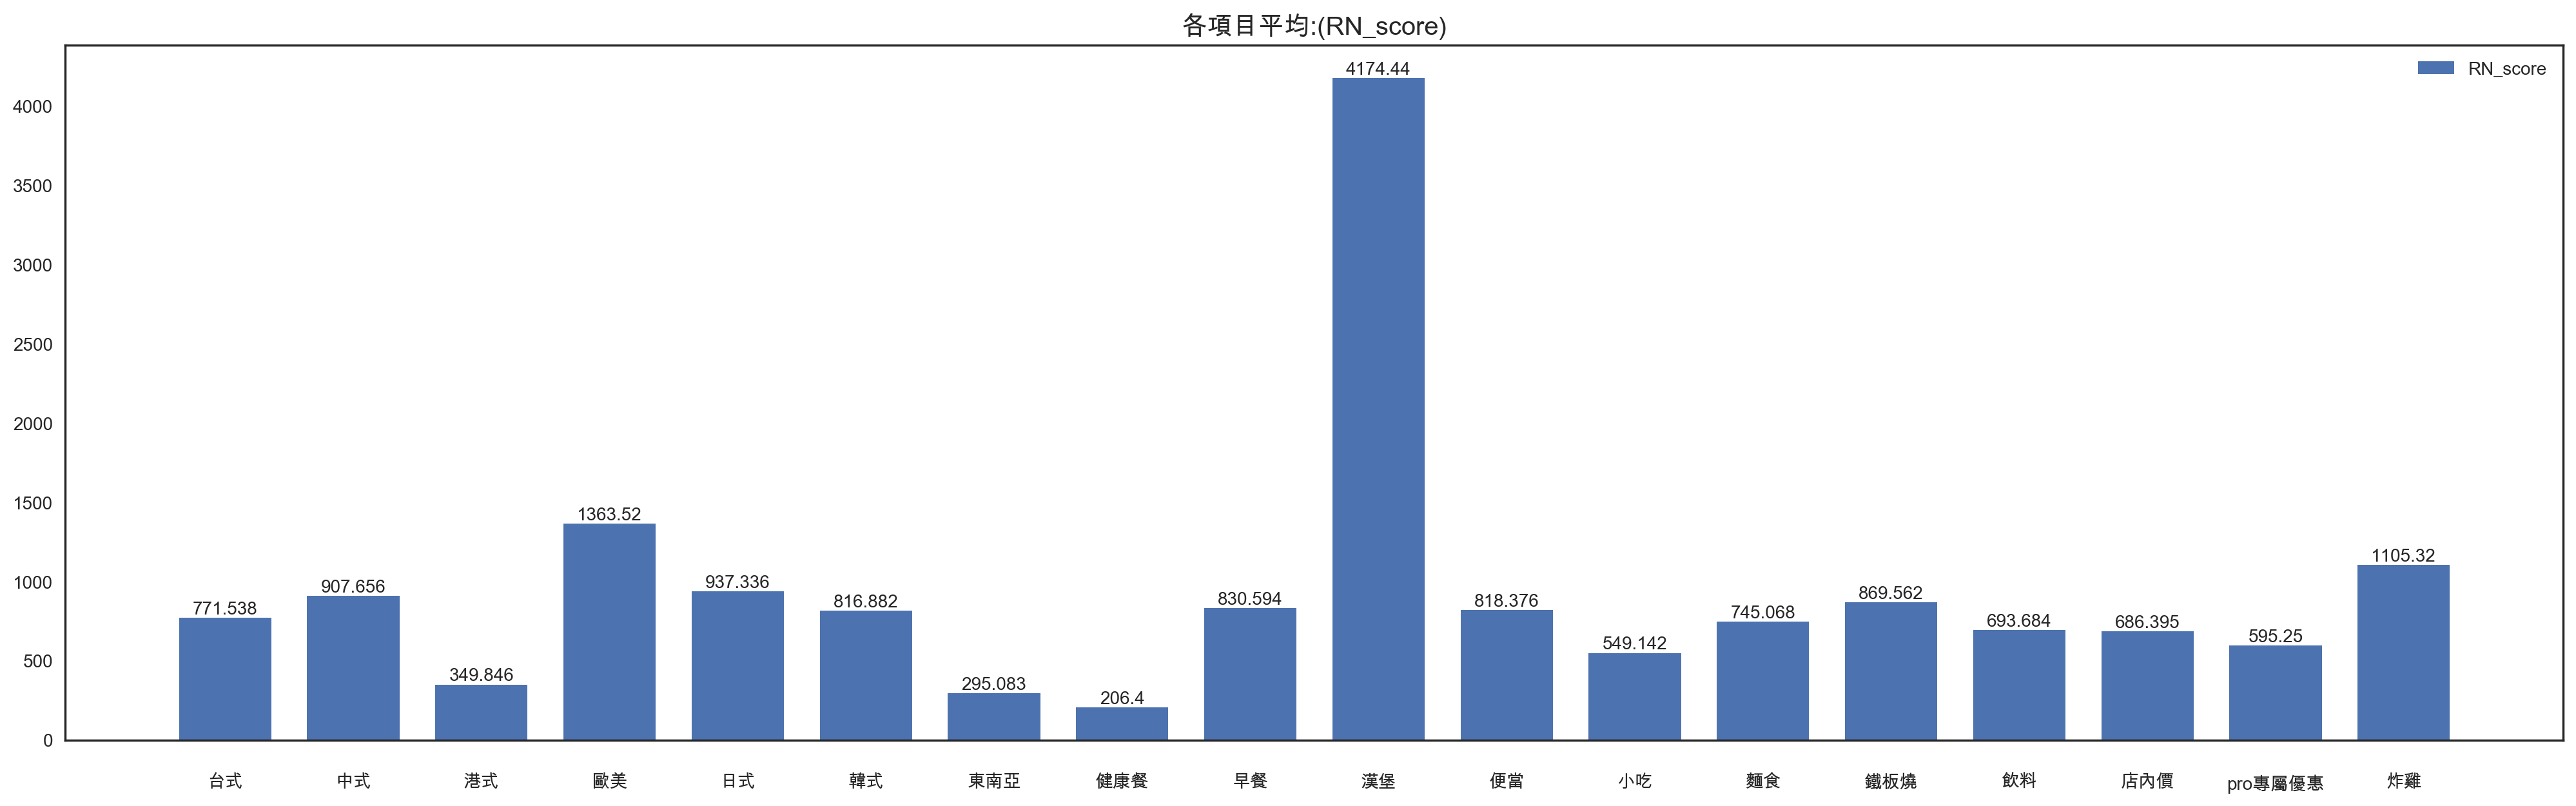

In [58]:
df_copy=df_rrv.copy()
x_label=df_copy.index
plot_data={"RN_score": df_rrv["RN_score"],}
fig, ax = plt.subplots(figsize=(25,7))
plt.xticks(range(18), x_label)
bar_plot(ax, plot_data ,total_width=.8, single_width=.9)
plt.title('各項目平均:(RN_score)')
pylab.rcParams['xtick.major.pad']='19'
plt.show()

- 各項目平均Vendor Points
- Vendor Points項目明顯高過其他

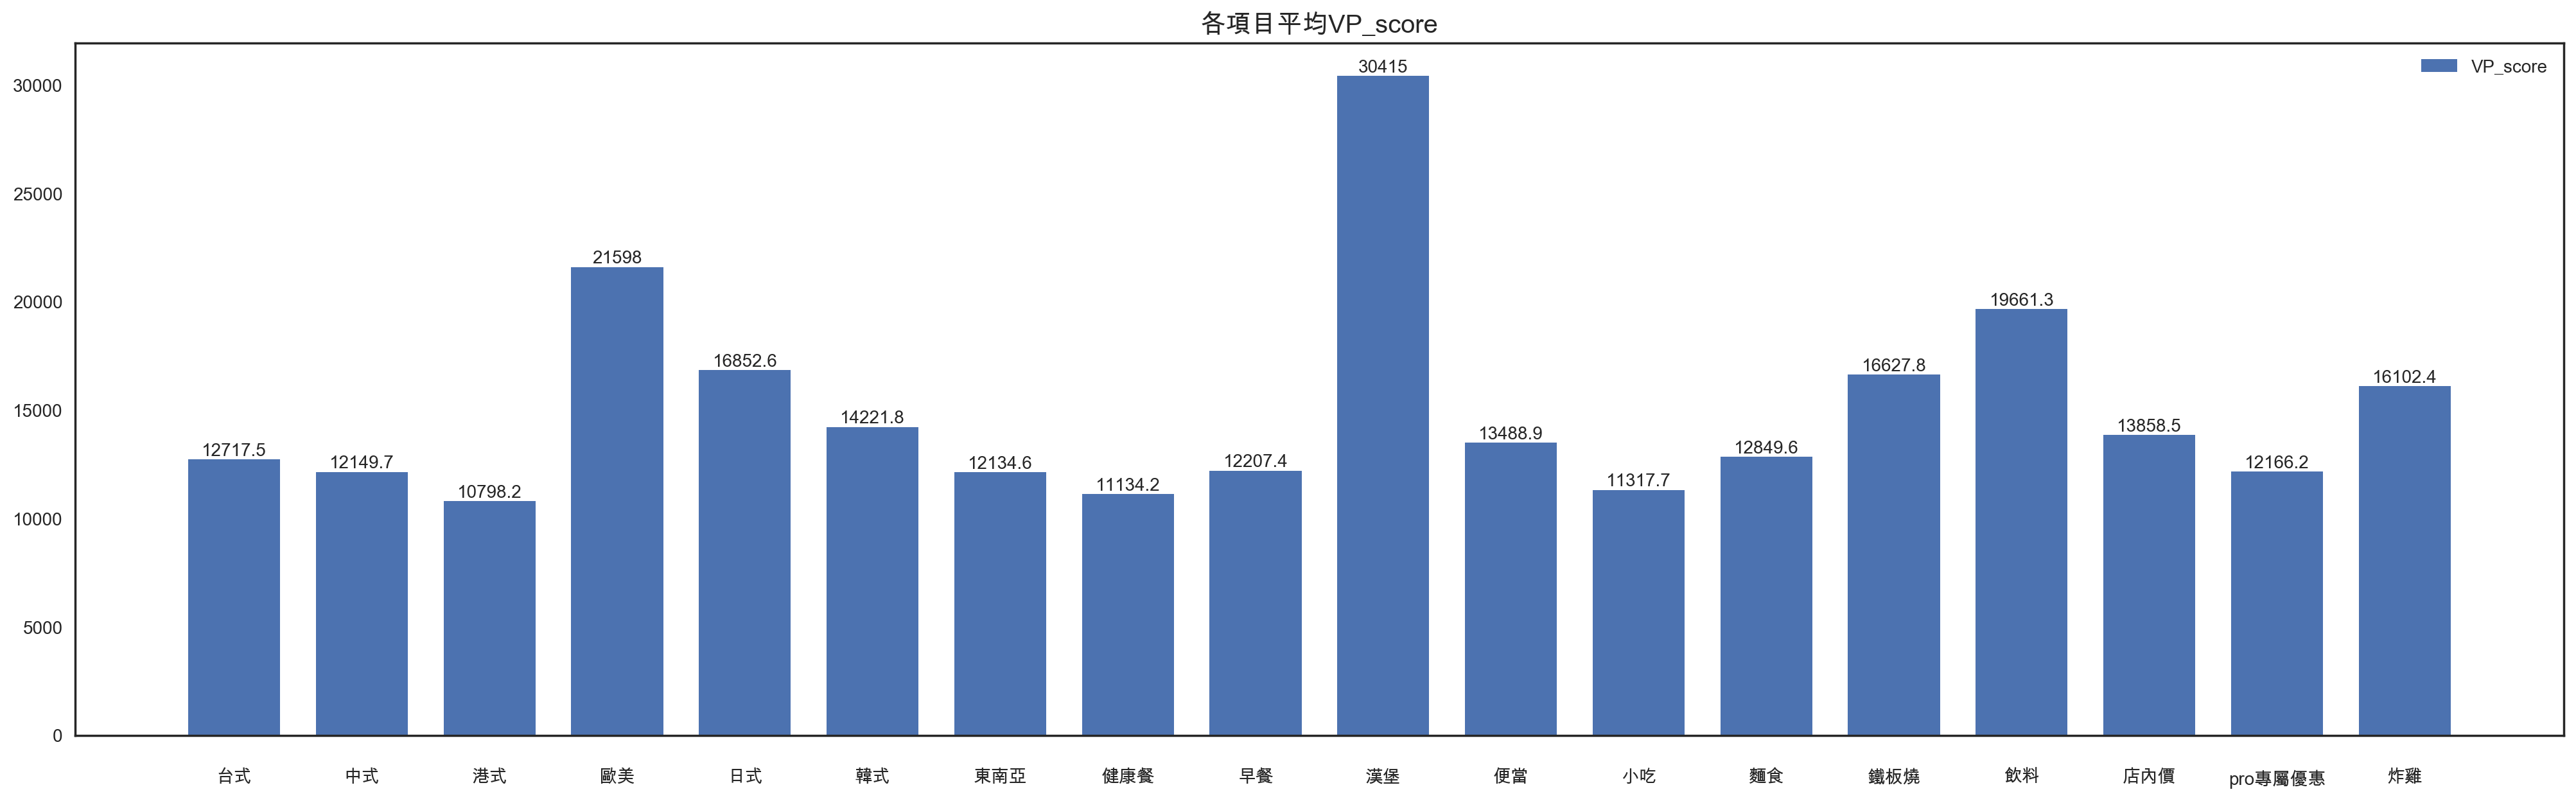

In [59]:
df_copy=df_rrv.copy()
x_label=df_copy.index
plot_data={"VP_score": df_rrv["VP_score"],}
fig, ax = plt.subplots(figsize=(25,7))
plt.xticks(range(18), x_label)
bar_plot(ax, plot_data ,total_width=.8, single_width=.9)
plt.title('各項目平均VP_score')
pylab.rcParams['xtick.major.pad']='19'
plt.show()

# Clustering: Rate、ReviewerNumber、VendorPoints

- 正規化func
- 分群model func

In [79]:
from sklearn_extra.cluster import KMedoids

In [98]:
df=df[df["Rate"]>4]

In [99]:
scale = MinMaxScaler()
def normalized_func(df_input):
    """ 正規化 """
    
    ## 保留index, Columns'name, 處理時會將此弄不見
    copy_idx = df_input.index
    copy_col = list(df_input.columns)
    normalized_df = df_input[copy_col].copy()
    
    ## scale
    normalized_df = pd.DataFrame(scale.fit_transform(normalized_df))
    
    ## 還原 index, 欄位名稱
    normalized_df = normalized_df.set_index(copy_idx)
    normalized_df.columns = copy_col
    return normalized_df

def kmeans_func(cluster_number, normalized_df):
    """ K-Means Model"""
    kmeans = KMeans(n_clusters=cluster_number, random_state=0, init='k-means++',max_iter=300,n_init=60)
    
    # kmeans = KMeans(n_clusters=cluster_number, random_state=0, init='k-means++',max_iter=500,tol=0.0001)
    kmeans.fit(normalized_df)
    
    Custcenter = kmeans.cluster_centers_
    Custcenter_reverse = scale.inverse_transform(Custcenter)
    labels = kmeans.labels_
    
    ## 
    cluster_df = normalized_df.copy(deep=True)
    cluster_df['Cluster'] = labels
    # correct = correct*1
    # correct_labels = sum(y== labels)
    
    sulhoutte_score = silhouette_score(normalized_df,labels)
    DB_score = davies_bouldin_score(normalized_df, labels)
    
    ## print score
    print("DB 指數",DB_score)
    print("CH 指數",calinski_harabasz_score(normalized_df,labels))
    
    inertia = kmeans.inertia_
    return kmeans, Custcenter, Custcenter_reverse, cluster_df, sulhoutte_score, inertia, labels


# K-Medoids
def kMedoids_func(cluster_number, normalized_df):
    """K-medoids, 以實點為中心的分群, 具體細節就不說明了XD"""
    # kMedoids
    kMedoids = KMedoids(n_clusters=cluster_number, random_state = 0)
    kMedoids.fit(normalized_df)
    # centers
    Custcenter = kMedoids.cluster_centers_
    # reverse center
    Custcenter_reverse = scale.inverse_transform(Custcenter)
    # inertia
    inertia = kMedoids.inertia_
    # labels
    labels = kMedoids.labels_
    # cluster_df
    cluster_df = normalized_df.copy(deep=True)
    cluster_df['Cluster'] = labels
    # score
    # score = kMedoids.fit_predict(normalized_df, labels)
    
    y_kmed = kMedoids.fit_predict(normalized_df)
    score = silhouette_score(normalized_df, y_kmed)
    sulhoutte_score = silhouette_score(normalized_df,labels)
    DB_score = davies_bouldin_score(normalized_df, labels)
    
    ## print score
    print("DB 指數",DB_score)
    print("CH 指數",calinski_harabasz_score(normalized_df,labels))
    
    return kMedoids, Custcenter, Custcenter_reverse, cluster_df, score, inertia, labels



- 目標欄位&群數決定

In [85]:

clustering_col=['Rate','Reviewer_Number','Vendor_Points']
# cluster_number=5

In [62]:
df_備份=df.copy()

# Find K

In [100]:
## Elbow Method
# clustering_col = ['R','F','M','Order']
clustering_col=['Rate','Reviewer_Number','Vendor_Points']
# clustering_col_rename = ['R','F','M','O']
clustering_col_rename=clustering_col
clustering_data1_for_model = df.copy()
clustering_data1_for_model=clustering_data1_for_model[clustering_col]
clustering_data1_for_model.columns=clustering_col_rename



distortion = [] # Elbow
silhouette_list = []
number_of_k = []



for i in range(2,16):
    cluster_number=i
    # clustering_data1 = rfm_df2.copy()
    normalized_df1=clustering_data1_for_model.copy()
    normalized_df1=normalized_func(normalized_df1)## selcet clustering data
    clustering_data_input = normalized_df1.copy() # original rfm
    kmeans, Custcenter, Custcenter_reverse, cluster_df, score, inertia, labels =  kmeans_func(cluster_number, clustering_data_input)
    # kmeans, Custcenter, Custcenter_reverse, cluster_df, score, inertia, labels =  kMedoids_func(cluster_number, clustering_data_input)
    distortion.append(inertia)
    silhouette_list.append(score)
    number_of_k.append(i)

DB 指數 0.679695530592542
CH 指數 1344.0799499771615
DB 指數 0.8540604386590823
CH 指數 1680.1944661869866
DB 指數 0.9490097575903693
CH 指數 1634.9621717984396
DB 指數 0.8796874034093246
CH 指數 1665.0427032570913
DB 指數 0.8941549675067962
CH 指數 1568.741977402913
DB 指數 0.9130552427472596
CH 指數 1549.662736087578
DB 指數 0.9482594653119447
CH 指數 1548.2912092649785
DB 指數 0.9490305251921214
CH 指數 1510.6052279112293
DB 指數 0.8856910857015455
CH 指數 1494.1479248146802
DB 指數 0.9086803524818687
CH 指數 1488.6833368925297
DB 指數 0.8999198952655849
CH 指數 1510.0700185259184
DB 指數 0.8732439343059375
CH 指數 1511.9204406108424
DB 指數 0.848941142310922
CH 指數 1488.9219195353512
DB 指數 0.8621961972929026
CH 指數 1476.1575290663257


- 最佳群數,我們不希望inertia(WCSS過高),也不希望silhouette太低,因此以3群作為分群數

,Number of K,Inertia,Silhouette score
0,2,83.259557,0.611088
1,3,52.867988,0.412057
2,4,41.304645,0.354390
3,5,33.076911,0.358101
4,6,29.154194,0.336332
5,7,25.444949,0.340129
6,8,22.421980,0.354576
7,9,20.451278,0.361074
8,10,18.658258,0.362364
9,11,17.075582,0.361333


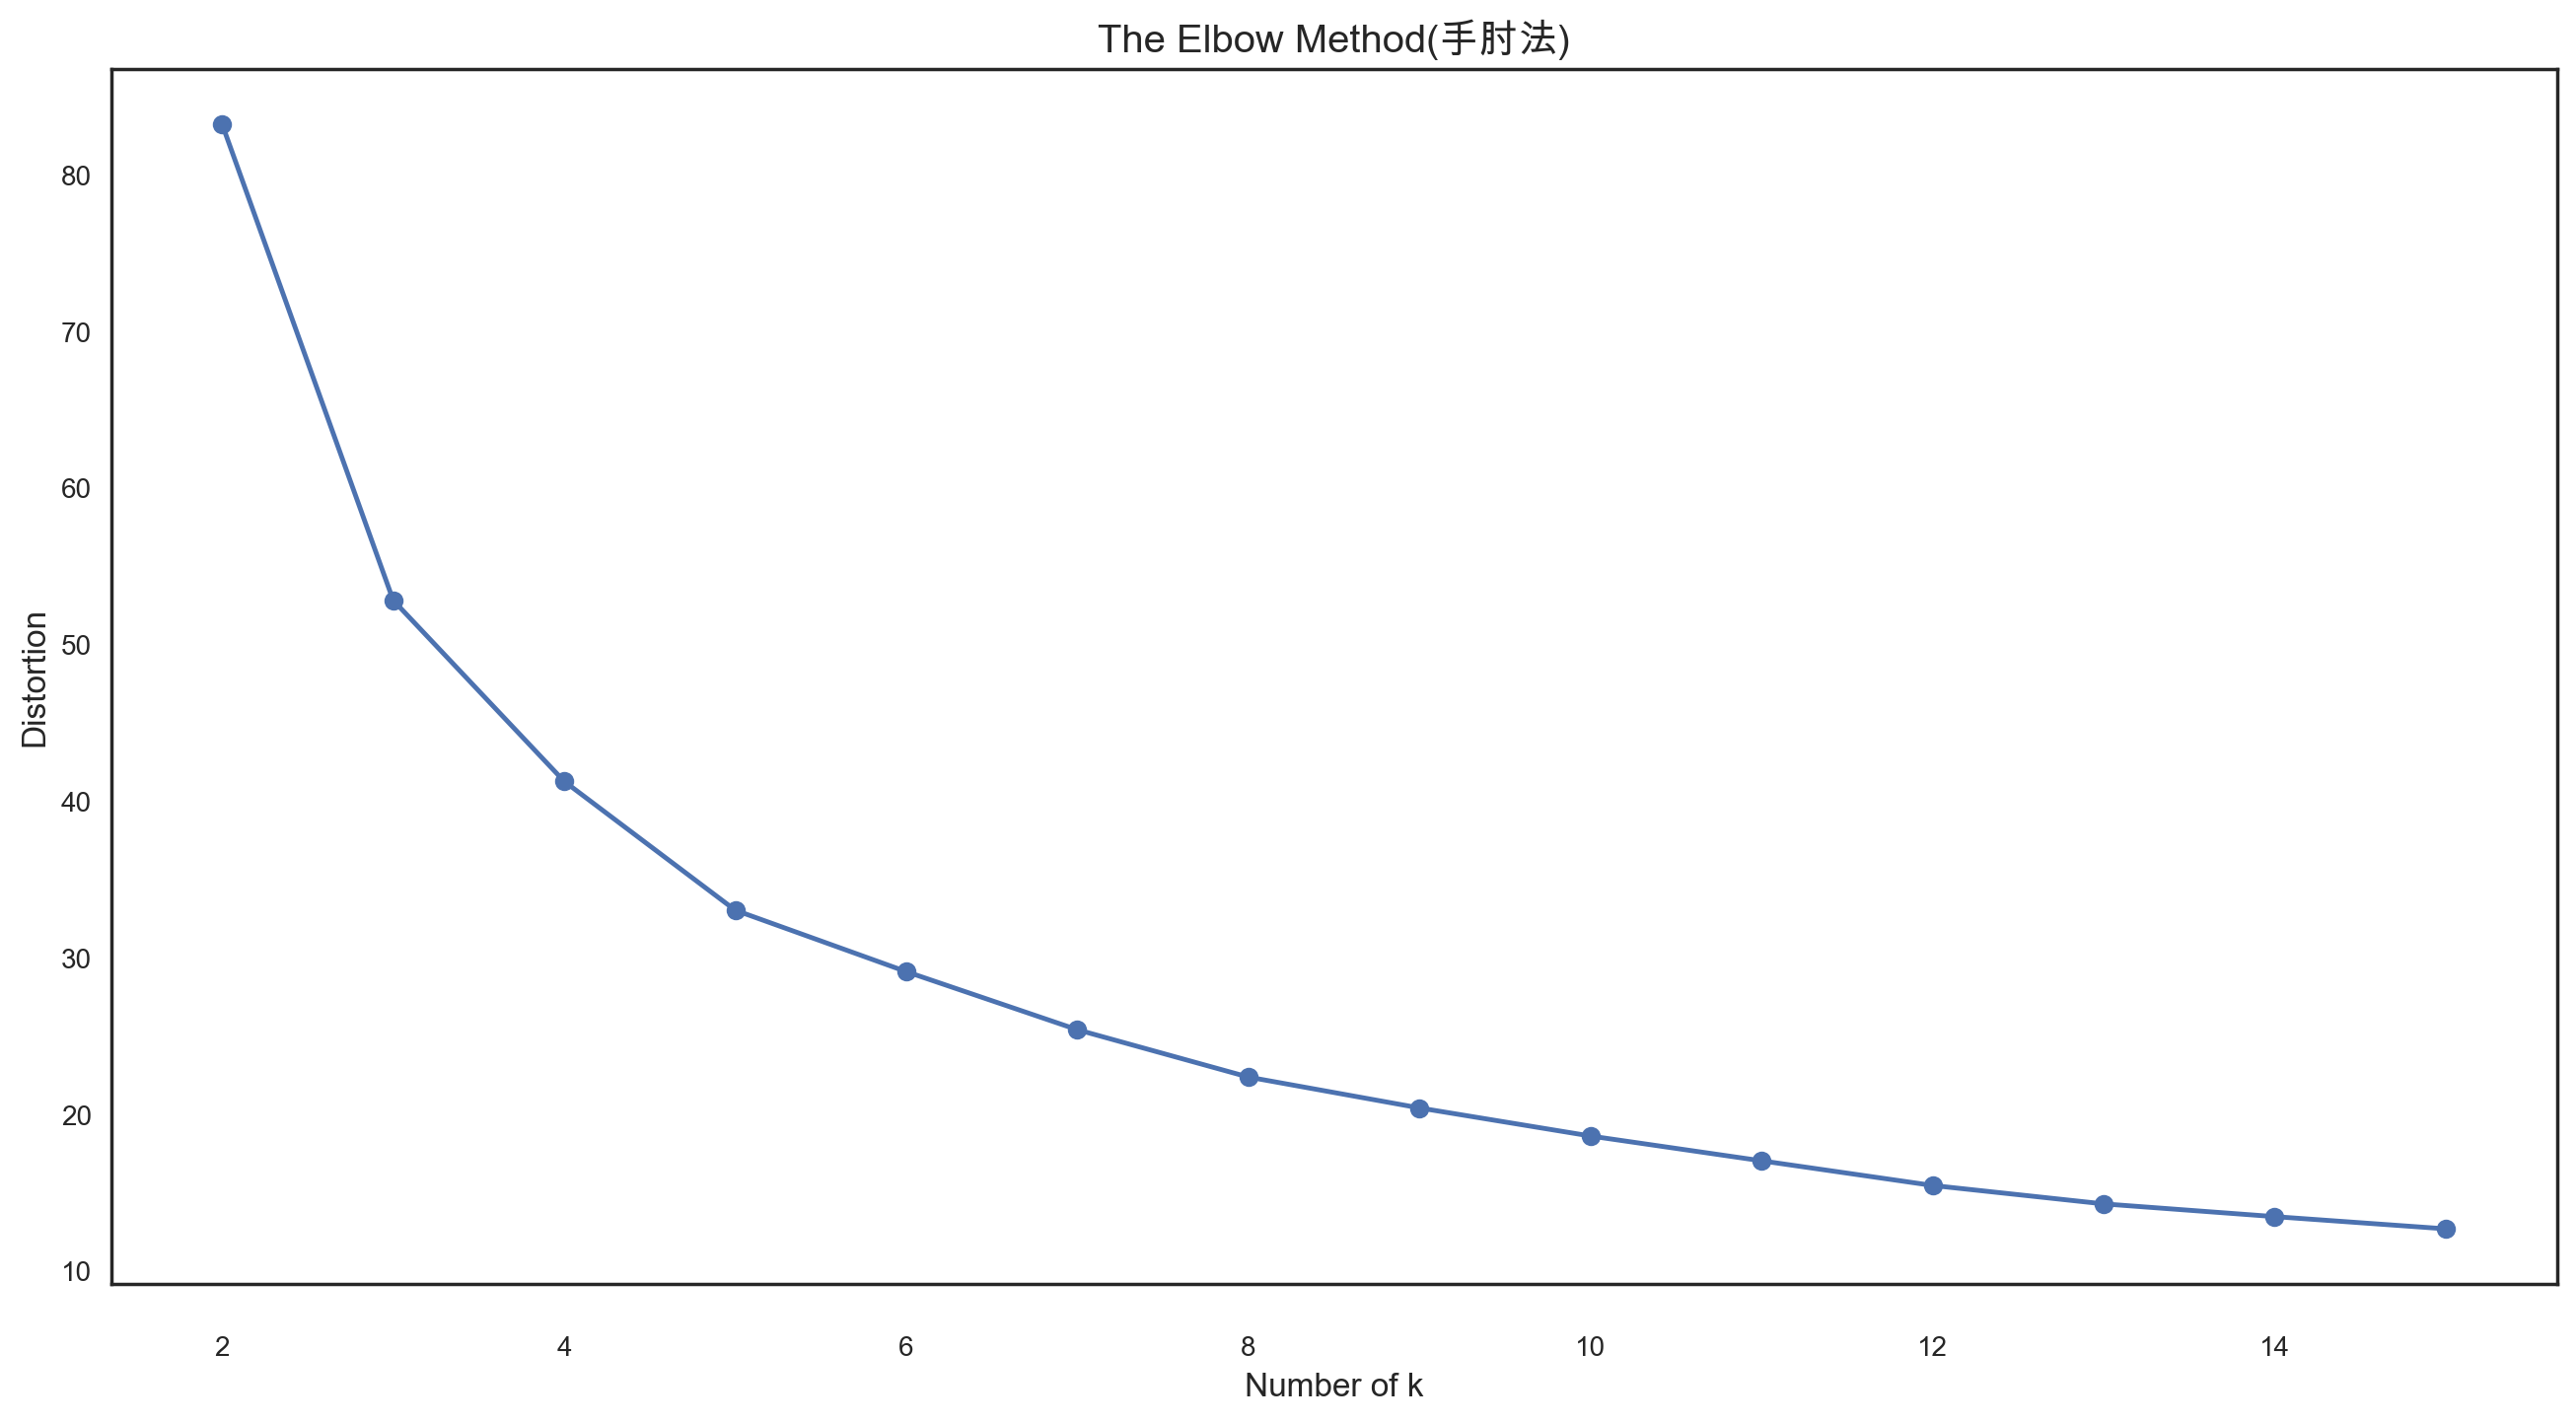

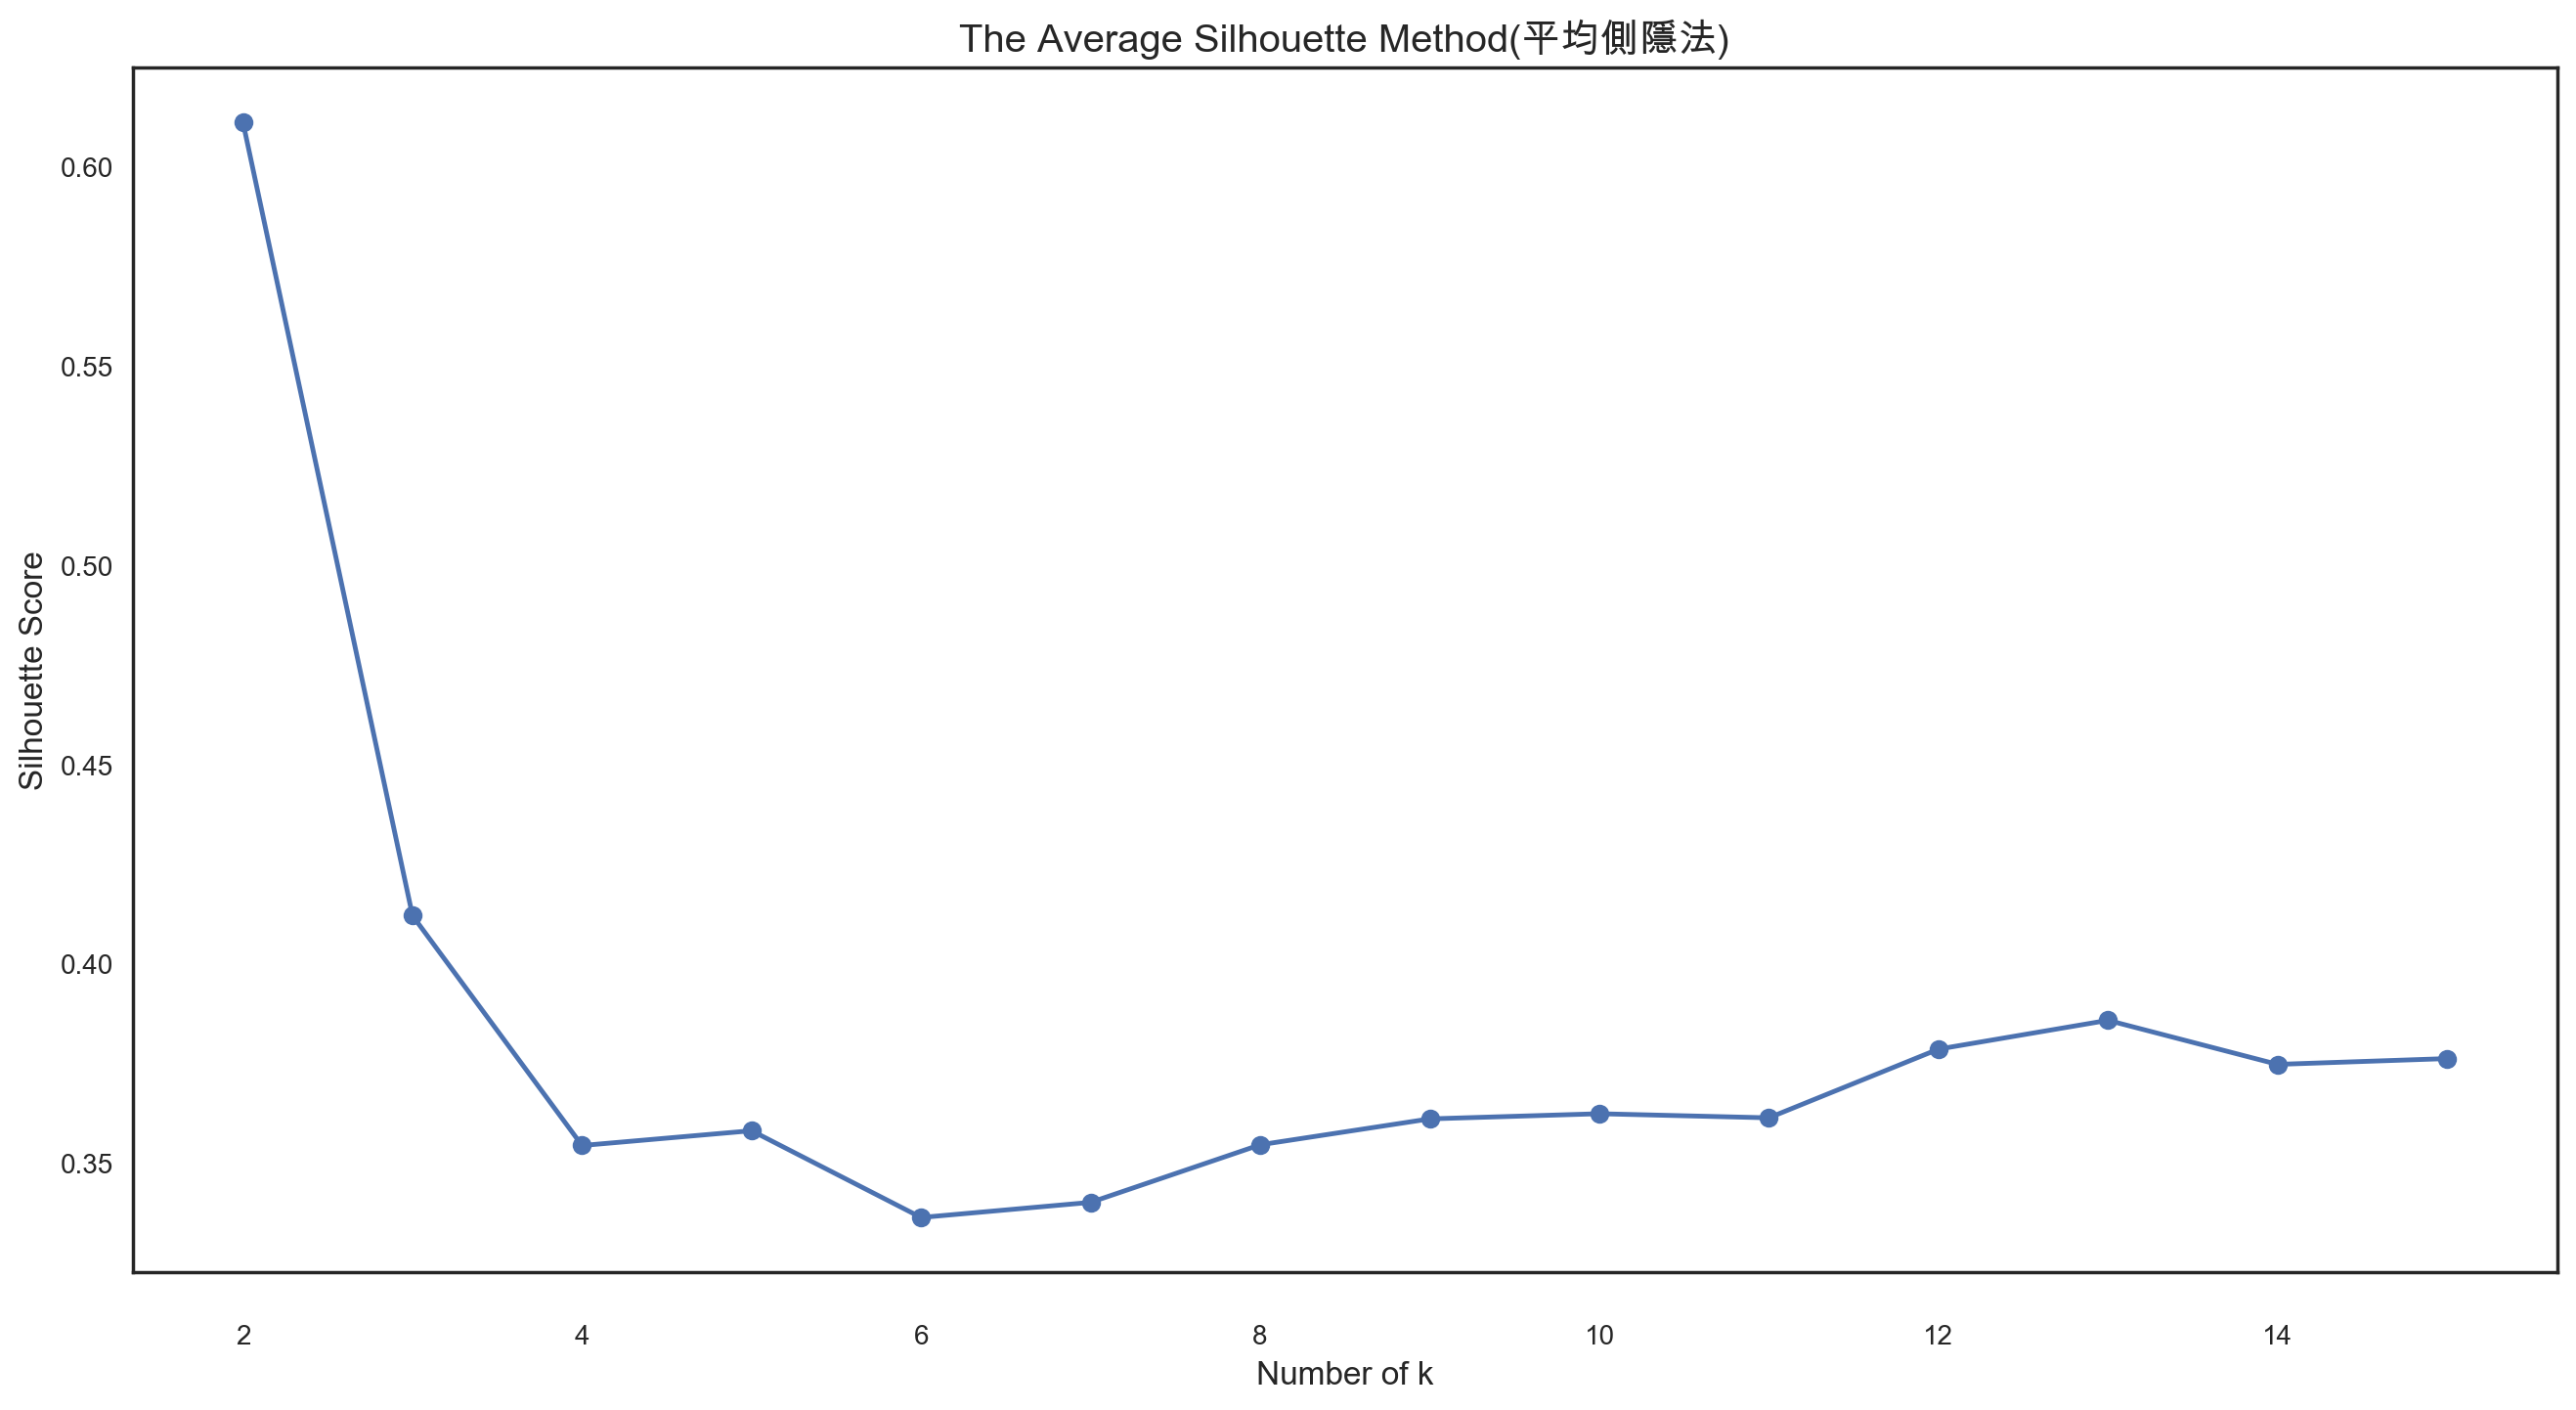

In [101]:
elbow_df = pd.DataFrame({
    "Number of K":number_of_k,
    "Inertia":distortion,
    "Silhouette score":silhouette_list
})
display(elbow_df)

plt.figure(figsize=(16,8))
plt.plot(elbow_df['Number of K'], elbow_df['Inertia'], marker='o',)
plt.xlabel('Number of k')
plt.ylabel('Distortion')
plt.title('The Elbow Method(手肘法)')
plt.show()


## 平均惻隱
plt.figure(figsize=(16,8))
plt.plot(elbow_df['Number of K'], elbow_df['Silhouette score'], marker='o',)
plt.xlabel('Number of k')
plt.ylabel('Silhouette Score')
plt.title('The Average Silhouette Method(平均側隱法)')
plt.show()



- 執行分群

In [102]:

cluster_number=5
clustering_data1 = df.copy()
normalized_df1=clustering_data1.copy()
normalized_df1=normalized_func(normalized_df1[clustering_col])## selcet clustering data
clustering_data_input = normalized_df1.copy() # original rfm
copy_features=df.copy()
## excute
# kmeans, Custcenter, Custcenter_reverse, cluster_df, score, inertia, labels =  kmeans_func(cluster_number, clustering_data_input)
kmeans, Custcenter, Custcenter_reverse, cluster_df, score, inertia, labels =  kMedoids_func(cluster_number, clustering_data_input)
## review_data
print("-----"*10)
print(f"群數: {cluster_number}")
print(f"intertia: {inertia}")
print(f"Silhouette score: {score}")
print(f"店家數(資料筆數): {len(clustering_data_input)}")
print("-----"*10)
## 看各群筆數
display(cluster_df.value_counts("Cluster").to_frame())
copy_features=df.copy()


DB 指數 1.7070158761921657
CH 指數 658.6888094609866
--------------------------------------------------
群數: 5
intertia: 291.67402111356614
Silhouette score: 0.15081736541923976
店家數(資料筆數): 2168
--------------------------------------------------


,0
Cluster,
0,724
3,664
4,437
1,208
2,135


In [103]:
# clustering_col=['Rate','Reviewer_Number','Vendor_Points']
## 抓 Cluster Label
cluster_label_frame = cluster_df.Cluster.to_frame()

## back to original data to add label
new_cluster_frame = pd.concat([copy_features,cluster_label_frame],axis=1)
display(new_cluster_frame)

new_cluster_frame_3d = new_cluster_frame.copy()
RFM_3d(1,new_cluster_frame_3d,'Vendor_Points','Rate','Reviewer_Number')
display(new_cluster_frame_3d)


,Restaurant_kind,Restaurant_name,RestaurantID,Restaurant_post,Rate,Reviewer_Number,Vendor_Points,ID_list,long_list,lat_list,...,早餐,麵食,小吃,健康餐,港式,台式,東南亞,pro專屬優惠,店內價,Cluster
0,披薩,達美樂 (路竹店),o5bn,821,4.8,627,37761,"179,165,179,55",22.860112,120.259328,...,0,0,0,0,0,0,0,0,1,2
1,便當,古早味排骨飯,x7wu,821,4.6,697,11503,"248,1215,248",22.860617,120.259923,...,0,0,0,0,0,1,0,0,0,0
2,火鍋,客友複合式休閒廣場,xvwq,821,4.6,335,10766,"248,1214,248,55",22.858492,120.256605,...,0,0,0,0,0,1,0,0,1,0
3,早餐,Say Hi 肆海豆漿,oqjp,821,4.8,418,9195,"214,198,214,257",22.862046,120.261017,...,1,0,1,0,0,0,0,1,0,3
4,麵食,停一下 Break Tea複合式餐廳(飲料、甜點、鍋燒),h05u,821,4.6,51,7111,"248,201,248,257",22.864878,120.263891,...,0,1,0,0,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,便當,宋主廚香菇肉羹、肉燥飯,rrqo,832,4.9,127,7366,"248,1215,248,55",22.503638,120.392875,...,0,0,0,0,0,1,0,0,1,3
2190,火鍋,五鮮級平價鍋物 (高雄林園店),nezf,832,4.6,293,10815,"248,1214,248,55",22.503831,120.383776,...,0,0,0,0,0,1,0,0,1,0
2191,東南亞,How2食堂,ftlk,832,4.5,16,8947,"252,252,257",22.503046,120.380359,...,0,0,0,0,0,0,1,1,0,3
2192,甜點,有米樂甜品,k0kh,832,4.8,252,9295,"176,176",22.503940,120.385452,...,0,0,0,0,0,0,0,0,0,3


,Restaurant_kind,Restaurant_name,RestaurantID,Restaurant_post,Rate,Reviewer_Number,Vendor_Points,ID_list,long_list,lat_list,...,早餐,麵食,小吃,健康餐,港式,台式,東南亞,pro專屬優惠,店內價,Cluster
0,披薩,達美樂 (路竹店),o5bn,821,4.8,627,37761,"179,165,179,55",22.860112,120.259328,...,0,0,0,0,0,0,0,0,1,2
1,便當,古早味排骨飯,x7wu,821,4.6,697,11503,"248,1215,248",22.860617,120.259923,...,0,0,0,0,0,1,0,0,0,0
2,火鍋,客友複合式休閒廣場,xvwq,821,4.6,335,10766,"248,1214,248,55",22.858492,120.256605,...,0,0,0,0,0,1,0,0,1,0
3,早餐,Say Hi 肆海豆漿,oqjp,821,4.8,418,9195,"214,198,214,257",22.862046,120.261017,...,1,0,1,0,0,0,0,1,0,3
4,麵食,停一下 Break Tea複合式餐廳(飲料、甜點、鍋燒),h05u,821,4.6,51,7111,"248,201,248,257",22.864878,120.263891,...,0,1,0,0,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,便當,宋主廚香菇肉羹、肉燥飯,rrqo,832,4.9,127,7366,"248,1215,248,55",22.503638,120.392875,...,0,0,0,0,0,1,0,0,1,3
2190,火鍋,五鮮級平價鍋物 (高雄林園店),nezf,832,4.6,293,10815,"248,1214,248,55",22.503831,120.383776,...,0,0,0,0,0,1,0,0,1,0
2191,東南亞,How2食堂,ftlk,832,4.5,16,8947,"252,252,257",22.503046,120.380359,...,0,0,0,0,0,0,1,1,0,3
2192,甜點,有米樂甜品,k0kh,832,4.8,252,9295,"176,176",22.503940,120.385452,...,0,0,0,0,0,0,0,0,0,3


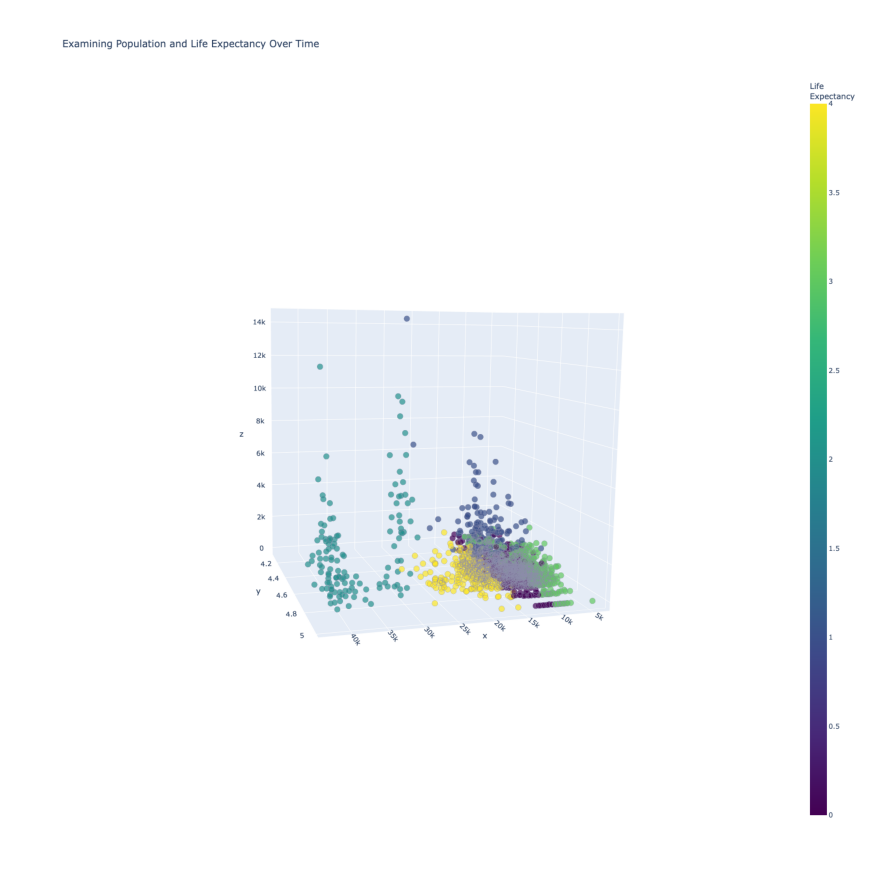

<Figure size 4000x1000 with 0 Axes>

In [113]:
png_func("/Users/hongshangren/Desktop/作品集ALL/foodpanda資料/newplot_after_clustering.png")

In [106]:
# new_cluster_frame_3d[new_cluster_frame_3d['Cluster']==1]
cluster0 = new_cluster_frame_3d[new_cluster_frame_3d['Cluster']==0]
cluster1 = new_cluster_frame_3d[new_cluster_frame_3d['Cluster']==1]
cluster2 = new_cluster_frame_3d[new_cluster_frame_3d['Cluster']==2]
cluster3 = new_cluster_frame_3d[new_cluster_frame_3d['Cluster']==3]
cluster4 = new_cluster_frame_3d[new_cluster_frame_3d['Cluster']==4]

In [107]:
cluster2

,Restaurant_kind,Restaurant_name,RestaurantID,Restaurant_post,Rate,Reviewer_Number,Vendor_Points,ID_list,long_list,lat_list,...,早餐,麵食,小吃,健康餐,港式,台式,東南亞,pro專屬優惠,店內價,Cluster
0,披薩,達美樂 (路竹店),o5bn,821,4.8,627,37761,"179,165,179,55",22.860112,120.259328,...,0,0,0,0,0,0,0,0,1,2
5,咖啡輕食,STARBUCKS 星巴克 (路竹門市),q9wt,821,4.8,1117,40870,"179,1206,179,181,55",22.868654,120.256047,...,0,0,0,0,0,0,0,0,1,2
6,漢堡,麥當勞 (S266 高雄路竹店),k0nl,821,4.8,7145,31327,"179,177,179",22.853921,120.261529,...,0,0,0,0,0,0,0,0,0,2
21,披薩,Pizza Hut必勝客 (高雄路竹店),c7ws,821,4.8,1567,39530,"179,165,179",22.860256,120.259425,...,0,0,0,0,0,0,0,0,0,2
98,披薩,達美樂 (旗山旗南店),l6kc,842,4.7,455,36672,"179,165,179,55",22.883097,120.478411,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,漢堡,麥當勞 (S198 高雄沿海店),b5fv,812,4.8,11978,42394,"179,177,179",22.569341,120.350147,...,0,0,0,0,0,0,0,0,0,2
1996,披薩,Pizza Hut必勝客 (高雄小港店),b0ah,812,4.7,3320,41275,"179,165,179",22.566911,120.353506,...,0,0,0,0,0,0,0,0,0,2
1997,披薩,達美樂 (小港宏平店),x6ax,812,4.6,804,39157,"179,165,179,55",22.570126,120.360768,...,0,0,0,0,0,0,0,0,1,2
2076,披薩,Pizza Hut必勝客 (高雄林園店),f9jr,832,4.8,1265,37241,"179,165,179",22.510937,120.394846,...,0,0,0,0,0,0,0,0,0,2
